### Import all dependencies and Preprocess Data

In [1]:
import pandas as pd
import re
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

### Data Loading and Merging

In [2]:
def load_excel_and_clean(path, value_name):
    # Extract the year from the filename
    match = re.search(r"(2019|2020|2021)", path)
    if match:
        year = int(match.group(0))
    else:
        raise ValueError("Year not found in the filename. Expected 2019, 2020, or 2021.")

    # Read all sheets
    xls = pd.read_excel(path, sheet_name=None)
    all_months = []

    for sheet_name, df in xls.items():
        # Clean column names
        df.columns = (
            df.columns.str.strip()
                      .str.lower()
                      .str.replace(' ', '_', regex=False)
        )

        df['month'] = sheet_name  # Add month from sheet name
        id_vars = ['circle', 'district', '33kv_feeder', 'month']

        # Identify columns like 'day_1', 'day_2', etc.
        day_cols = [c for c in df.columns if c.startswith('day_')]
        
        # Melt to long format
        df_long = df.melt(
            id_vars=id_vars,
            value_vars=day_cols,
            var_name='day',
            value_name=value_name
        )

        # Clean day column and convert to int
        df_long['day'] = df_long['day'].str.replace('day_', '').astype(int)

        # Convert month name to month number
        df_long['month'] = pd.to_datetime(df_long['month'], format='%b').dt.month

        # Construct datetime column
        df_long['date'] = pd.to_datetime({
            'year': year,
            'month': df_long['month'],
            'day': df_long['day']
        }, errors='coerce')  # coerce invalid dates like Feb 30 to NaT

        # Drop redundant columns
        df_long = df_long.drop(columns=['month', 'day'])

        all_months.append(df_long)

    # Concatenate all sheets
    final_df = pd.concat(all_months, ignore_index=True)

    # Optional: drop rows with invalid dates
    final_df = final_df.dropna(subset=['date'])

    return final_df

In [3]:
# list availability data paths
avail_path_2019 = r'C:\Users\pc\Documents\Power System Planning\data\33KV Daily Availability 2019.xlsx'
avail_path_2020 = r'C:\Users\pc\Documents\Power System Planning\data\33KV Daily Availability 2020.xlsx'
avail_path_2021 = r'C:\Users\pc\Documents\Power System Planning\data\33KV Daily Availability 2021.xlsx'

#list consumption data paths
cons_path_2019 = r'C:\Users\pc\Documents\Power System Planning\data\33KV Daily Consumption 2019.xlsx'
cons_path_2020 = r'C:\Users\pc\Documents\Power System Planning\data\33KV Daily Consumption 2020.xlsx'
cons_path_2021 = r'C:\Users\pc\Documents\Power System Planning\data\33KV Daily Consumption 2021.xlsx'


In [4]:
#Load Availability data
avail_2019 = load_excel_and_clean(avail_path_2019, 'availability_hrs')
avail_2020 = load_excel_and_clean(avail_path_2020, 'availability_hrs')
avail_2021 = load_excel_and_clean(avail_path_2021, 'availability_hrs')

#Load Consumption data
cons_2019 = load_excel_and_clean(cons_path_2019, 'consumption_mwh')
cons_2020 = load_excel_and_clean(cons_path_2020, 'consumption_mwh')
cons_2021 = load_excel_and_clean(cons_path_2021, 'consumption_mwh')


c:\Users\pc\Documents\Power System Planning\.venv\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Web Extension extension is not supported and will be removed
  warn(msg)


In [5]:
# Inspect all availability and consumption shapes
#Inspect availability data shapes
print(f"Availability_2019 rows: {avail_2019.shape[0]}")
print(f"Availability_2020 rows: {avail_2020.shape[0]}")
print(f"Availability_2021 rows: {avail_2021.shape[0]}")

#Inspect consumption data shapes
print(f"Consumption_2019 rows: {cons_2019.shape[0]}")
print(f"Consumption_2020 rows: {cons_2020.shape[0]}")
print(f"Consumption_2021 rows: {cons_2021.shape[0]}")

Availability_2019 rows: 31755
Availability_2020 rows: 32632
Availability_2021 rows: 30060
Consumption_2019 rows: 31816
Consumption_2020 rows: 32574
Consumption_2021 rows: 30394


In [6]:
#merge all availability data
avail_all = pd.concat([avail_2019, avail_2020, avail_2021], ignore_index=True)
#merge all consumption data
cons_all = pd.concat([cons_2019, cons_2020, cons_2021], ignore_index=True)
# Inspect merged availability and consumption shapes
print(f"Availability_all rows: {avail_all.shape[0]}")
print(f"Consumption_all rows: {cons_all.shape[0]}")

Availability_all rows: 94447
Consumption_all rows: 94784


In [7]:
avail_all

circle district          33kv_feeder  availability_hrs       date
0      CENTRAL    APAPA       AMUWO LOCAL T3              24.0 2019-01-01
1      CENTRAL    APAPA        APAPA MAINS 1              24.0 2019-01-01
2      CENTRAL    APAPA        APAPA MAINS 2              24.0 2019-01-01
3      CENTRAL    APAPA  APAPA ROAD LOCAL T1              21.0 2019-01-01
4      CENTRAL    APAPA  APAPA ROAD LOCAL T2              24.0 2019-01-01
...        ...      ...                  ...               ...        ...
94442     WEST      OJO       FESTAC 1 (OJO)               8.0 2021-11-30
94443     WEST      OJO         OJO LOCAL T1              24.0 2021-11-30
94444     WEST      OJO         OJO LOCAL T2               0.0 2021-11-30
94445     WEST      OJO         OJO LOCAL T3              24.0 2021-11-30
94446     WEST      OJO           VOLKSWAGEN               0.0 2021-11-30

[94447 rows x 5 columns]

In [8]:
cons_all

circle district          33kv_feeder consumption_mwh       date
0      CENTRAL    APAPA       AMUWO LOCAL T3           191.0 2019-01-01
1      CENTRAL    APAPA        APAPA MAINS 1            75.0 2019-01-01
2      CENTRAL    APAPA        APAPA MAINS 2            22.0 2019-01-01
3      CENTRAL    APAPA  APAPA ROAD LOCAL T1           135.3 2019-01-01
4      CENTRAL    APAPA  APAPA ROAD LOCAL T2           192.3 2019-01-01
...        ...      ...                  ...             ...        ...
94779     WEST      OJO       FESTAC 1 (OJO)           119.0 2021-11-30
94780     WEST      OJO         OJO LOCAL T1           119.2 2021-11-30
94781     WEST      OJO         OJO LOCAL T2             0.0 2021-11-30
94782     WEST      OJO         OJO LOCAL T3           120.9 2021-11-30
94783     WEST      OJO           VOLKSWAGEN             0.0 2021-11-30

[94784 rows x 5 columns]

In [9]:
# Merge on circle, district, feeder, month, and day
df_merged = pd.merge(
    avail_all, 
    cons_all, 
    on=['circle', 'district', '33kv_feeder', 'date'],
    how='inner'
)

# Preview merged data
df_merged.head()

circle district          33kv_feeder  availability_hrs       date  \
0  CENTRAL    APAPA       AMUWO LOCAL T3              24.0 2019-01-01   
1  CENTRAL    APAPA        APAPA MAINS 1              24.0 2019-01-01   
2  CENTRAL    APAPA        APAPA MAINS 2              24.0 2019-01-01   
3  CENTRAL    APAPA  APAPA ROAD LOCAL T1              21.0 2019-01-01   
4  CENTRAL    APAPA  APAPA ROAD LOCAL T2              24.0 2019-01-01   

  consumption_mwh  
0           191.0  
1            75.0  
2            22.0  
3           135.3  
4           192.3

In [10]:
len(df_merged["district"].unique())

10

In [11]:
# Reorder columns to make 'date' the first column
cols = ['date'] + [col for col in df_merged.columns if col != 'date']
df_merged = df_merged[cols]
df_merged

date   circle district          33kv_feeder  availability_hrs  \
0     2019-01-01  CENTRAL    APAPA       AMUWO LOCAL T3              24.0   
1     2019-01-01  CENTRAL    APAPA        APAPA MAINS 1              24.0   
2     2019-01-01  CENTRAL    APAPA        APAPA MAINS 2              24.0   
3     2019-01-01  CENTRAL    APAPA  APAPA ROAD LOCAL T1              21.0   
4     2019-01-01  CENTRAL    APAPA  APAPA ROAD LOCAL T2              24.0   
...          ...      ...      ...                  ...               ...   
94384 2021-11-30     WEST      OJO       FESTAC 1 (OJO)               8.0   
94385 2021-11-30     WEST      OJO         OJO LOCAL T1              24.0   
94386 2021-11-30     WEST      OJO         OJO LOCAL T2               0.0   
94387 2021-11-30     WEST      OJO         OJO LOCAL T3              24.0   
94388 2021-11-30     WEST      OJO           VOLKSWAGEN               0.0   

      consumption_mwh  
0               191.0  
1                75.0  
2                22.0  
3               135.3  
4               192.3  
...               ...  
94384           119.0  
94385           119.2  
94386             0.0  
94387           120.9  
94388             0.0  

[94389 rows x 6 columns]

In [12]:
# df_merged = df_merged.drop(columns=['circle'])
# df_merged.head()

In [13]:
clean_data_path = r'C:\Users\pc\Documents\Power System Planning\cleaned_data'
if not os.path.exists(clean_data_path):
    os.makedirs(clean_data_path)

# Save the merged DataFrame to a CSV file
df_merged.to_csv(os.path.join(clean_data_path, 'merged_data.csv'), index=False)

In [14]:
df_merged.shape

(94389, 6)

### Exploratory Data Analysis (EDA)

In [15]:
# Convert 'availability_hrs' and 'consumption_mwh' column to numeric, coercing errors to NaN
df_merged['availability_hrs'] = pd.to_numeric(df_merged['availability_hrs'], errors='coerce')
df_merged['consumption_mwh'] = pd.to_numeric(df_merged['consumption_mwh'], errors='coerce')

In [16]:
#Give a statistical description of the data
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94389 entries, 0 to 94388
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              94389 non-null  datetime64[ns]
 1   circle            94389 non-null  object        
 2   district          94389 non-null  object        
 3   33kv_feeder       94389 non-null  object        
 4   availability_hrs  94389 non-null  float64       
 5   consumption_mwh   94388 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 4.3+ MB


In [17]:
data_stat= df_merged.describe()
data_stat.to_csv(os.path.join(clean_data_path, 'data_stat.csv'))


In [18]:
max_avail = df_merged['availability_hrs'].max()
max_avail

np.float64(24.0)

In [19]:
# Find the maximum value in the 'consumption_mwh' column
max_cons = df_merged['consumption_mwh'].max()
max_cons

np.float64(2508.5)

In [20]:
# Check for missing values
df_merged.isnull().sum()


date                0
circle              0
district            0
33kv_feeder         0
availability_hrs    0
consumption_mwh     1
dtype: int64

In [21]:
#Drop the rows with missing values in 'consumption_mwh'
df_merged = df_merged.dropna(subset=['consumption_mwh'])

df_merged.isnull().sum()

date                0
circle              0
district            0
33kv_feeder         0
availability_hrs    0
consumption_mwh     0
dtype: int64

#### Distribution of Data

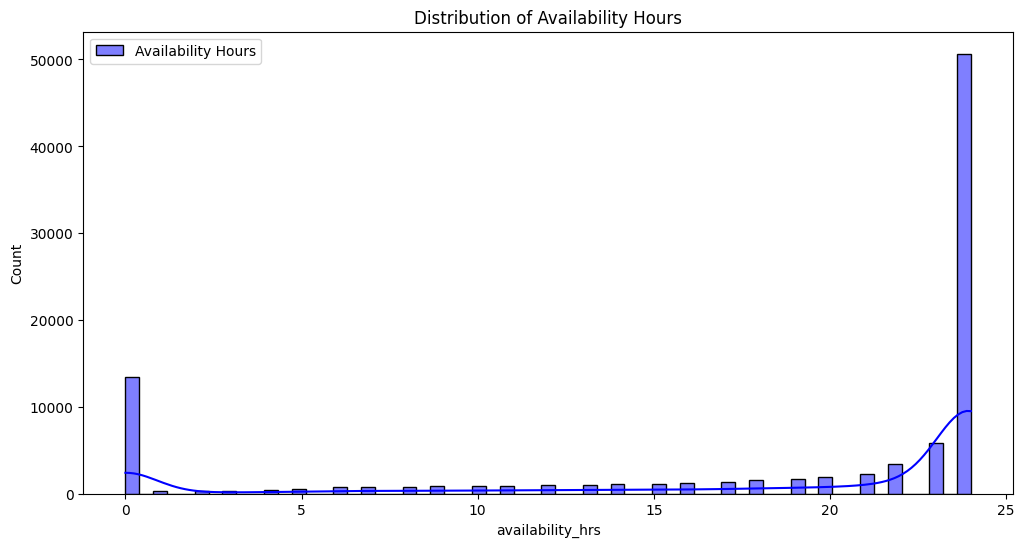

In [22]:
# Plot histograms for availability and consumption
plt.figure(figsize=(12,6))
sns.histplot(df_merged['availability_hrs'], kde=True, color='blue', label='Availability Hours')
#sns.histplot(df_merged['consumption_mwh'], kde=True, color='orange', label='Consumption (MWh)')
plt.legend()
plt.title('Distribution of Availability Hours')
plt.show()


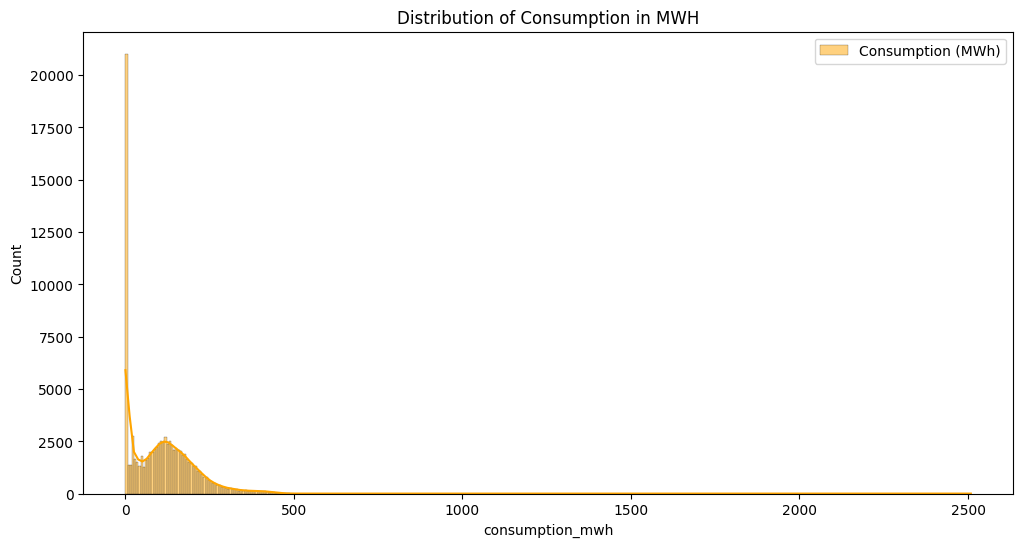

In [23]:
# Plot histograms for availability and consumption
plt.figure(figsize=(12,6))
#sns.histplot(df_merged['availability_hrs'], kde=True, color='blue', label='Availability Hours')
sns.histplot(df_merged['consumption_mwh'], kde=True, color='orange', label='Consumption (MWh)')
plt.legend()
plt.title('Distribution of Consumption in MWH')
plt.show()


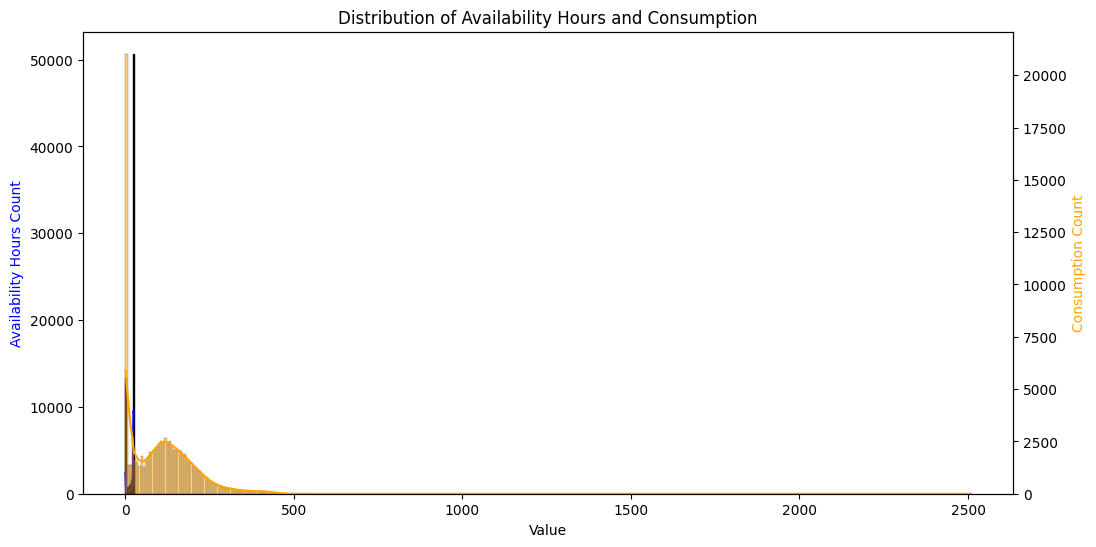

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot for availability_hours on the left axis
sns.histplot(df_merged['availability_hrs'], kde=True, color='blue', ax=ax1, label='Availability Hours')
ax1.set_ylabel('Availability Hours Count', color='blue')

# Create the second y-axis
ax2 = ax1.twinx()
sns.histplot(df_merged['consumption_mwh'], kde=True, color='orange', ax=ax2, label='Consumption (MWh)')
ax2.set_ylabel('Consumption Count', color='orange')

# Adding labels and title
ax1.set_xlabel('Value')
plt.title('Distribution of Availability Hours and Consumption')

# Show the plot
plt.show()


In [25]:
df_merged

date   circle district          33kv_feeder  availability_hrs  \
0     2019-01-01  CENTRAL    APAPA       AMUWO LOCAL T3              24.0   
1     2019-01-01  CENTRAL    APAPA        APAPA MAINS 1              24.0   
2     2019-01-01  CENTRAL    APAPA        APAPA MAINS 2              24.0   
3     2019-01-01  CENTRAL    APAPA  APAPA ROAD LOCAL T1              21.0   
4     2019-01-01  CENTRAL    APAPA  APAPA ROAD LOCAL T2              24.0   
...          ...      ...      ...                  ...               ...   
94384 2021-11-30     WEST      OJO       FESTAC 1 (OJO)               8.0   
94385 2021-11-30     WEST      OJO         OJO LOCAL T1              24.0   
94386 2021-11-30     WEST      OJO         OJO LOCAL T2               0.0   
94387 2021-11-30     WEST      OJO         OJO LOCAL T3              24.0   
94388 2021-11-30     WEST      OJO           VOLKSWAGEN               0.0   

       consumption_mwh  
0                191.0  
1                 75.0  
2                 22.0  
3                135.3  
4                192.3  
...                ...  
94384            119.0  
94385            119.2  
94386              0.0  
94387            120.9  
94388              0.0  

[94388 rows x 6 columns]

In [26]:
df_merged[df_merged['district'] == 'LEKKI']['33kv_feeder'].nunique()

11

In [27]:
df_merged["district"].unique()

array(['APAPA', 'IJORA', 'MUSHIN', 'ORILE', 'IBEJU', 'ISLAND', 'LEKKI',
       'AGBARA', 'FESTAC', 'OJO'], dtype=object)

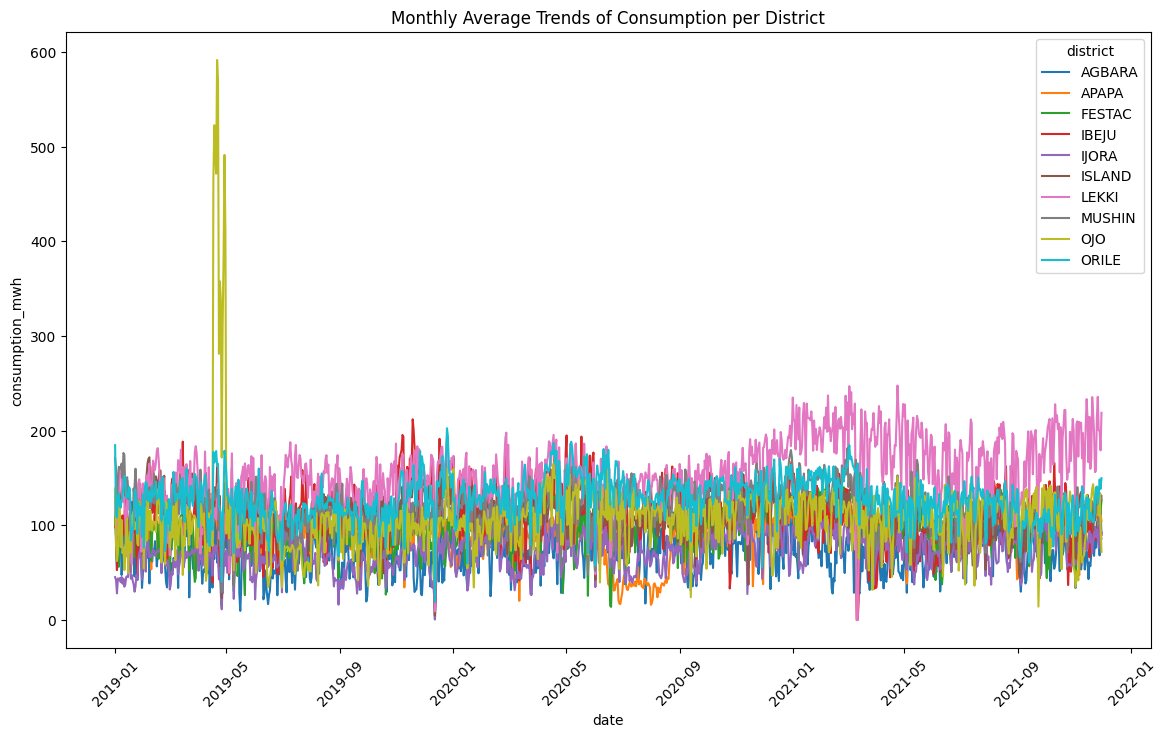

In [28]:
# Plot the monthly average of availability and consumption per feeder
monthly_avg = df_merged.groupby(['date', 'district']).agg({
    'availability_hrs': 'mean',
    'consumption_mwh': 'mean'
}).reset_index()

# Plot the trends
plt.figure(figsize=(14,8))
#sns.lineplot(x='month', y='availability_hrs', hue='district', data=monthly_avg)
sns.lineplot(x='date', y='consumption_mwh', hue='district', data=monthly_avg)
plt.title('Monthly Average Trends of Consumption per District')
plt.xticks(rotation=45)
plt.show()


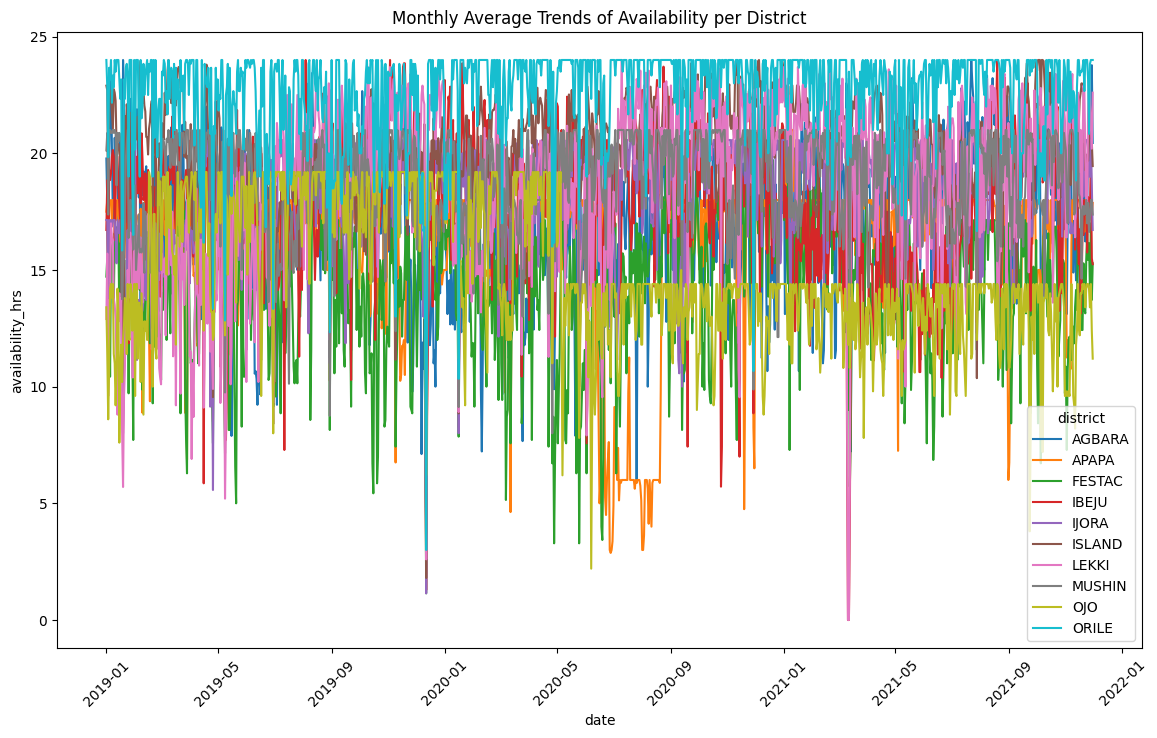

In [29]:
# Plot the monthly average of availability and consumption per feeder
monthly_avg = df_merged.groupby(['date', 'district']).agg({
    'availability_hrs': 'mean',
    'consumption_mwh': 'mean'
}).reset_index()

# Plot the trends using date as x-axis
plt.figure(figsize=(14,8))
sns.lineplot(x='date', y='availability_hrs', hue='district', data=monthly_avg)
#sns.lineplot(x='date', y='consumption_mwh', hue='district', data=monthly_avg)
plt.title('Monthly Average Trends of Availability per District')
plt.xticks(rotation=45)
plt.show()

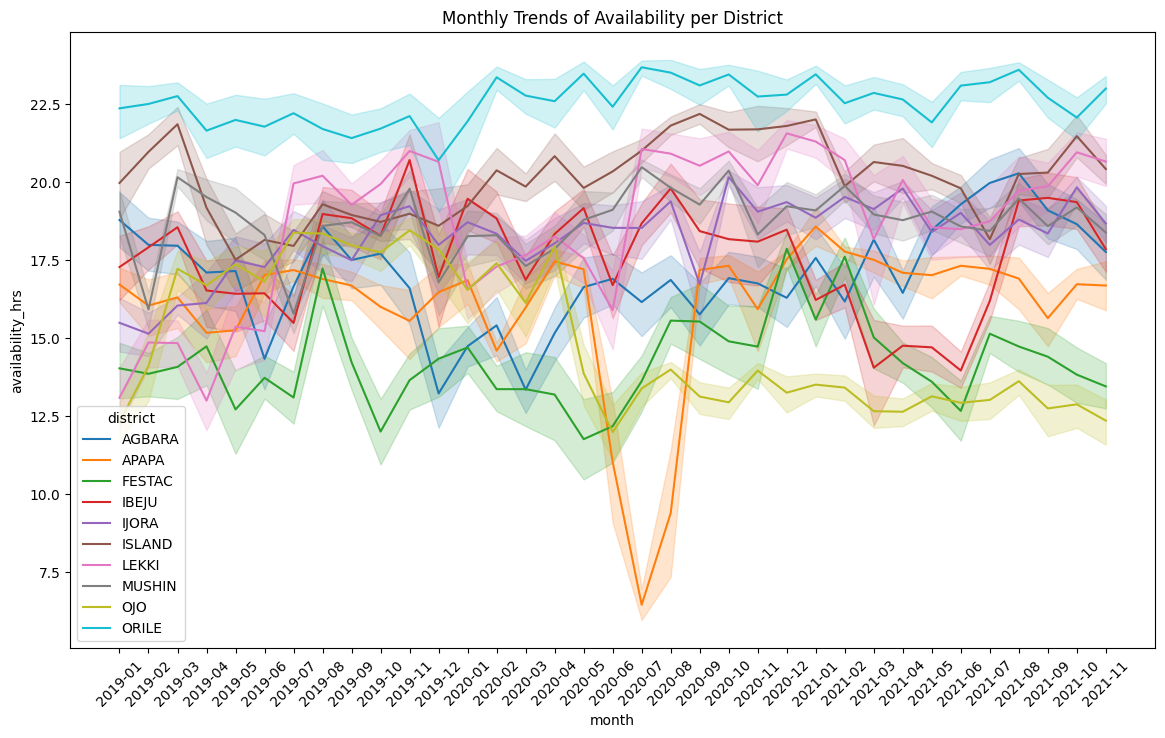

In [30]:
# Plot the monthly average of availability and consumption per feeder
monthly_avg = df_merged.groupby(['date', 'district']).agg({
    'availability_hrs': 'mean',
    'consumption_mwh': 'mean'
}).reset_index()

# Add a 'month' column for plotting
monthly_avg['month'] = monthly_avg['date'].dt.to_period('M').astype(str)

# Plot the trends
plt.figure(figsize=(14,8))
sns.lineplot(x='month', y='availability_hrs', hue='district', data=monthly_avg)
#sns.lineplot(x='month', y='consumption_mwh', hue='district', data=monthly_avg)
plt.title('Monthly Trends of Availability per District')
plt.xticks(rotation=45)
plt.show()


### Main Data Analysis

In [31]:
# Zero availability feeders count per district per day
zero_avail = df_merged[df_merged['availability_hrs'] == 0]
zero_avail_count = zero_avail.groupby(['district'])['33kv_feeder'] \
                             .nunique().reset_index(name='num_zero_avail_feeders')

zero_avail_count

district  num_zero_avail_feeders
0   AGBARA                       9
1    APAPA                       8
2   FESTAC                       7
3    IBEJU                       8
4    IJORA                       7
5   ISLAND                      22
6    LEKKI                      11
7   MUSHIN                       8
8      OJO                       5
9    ORILE                       6

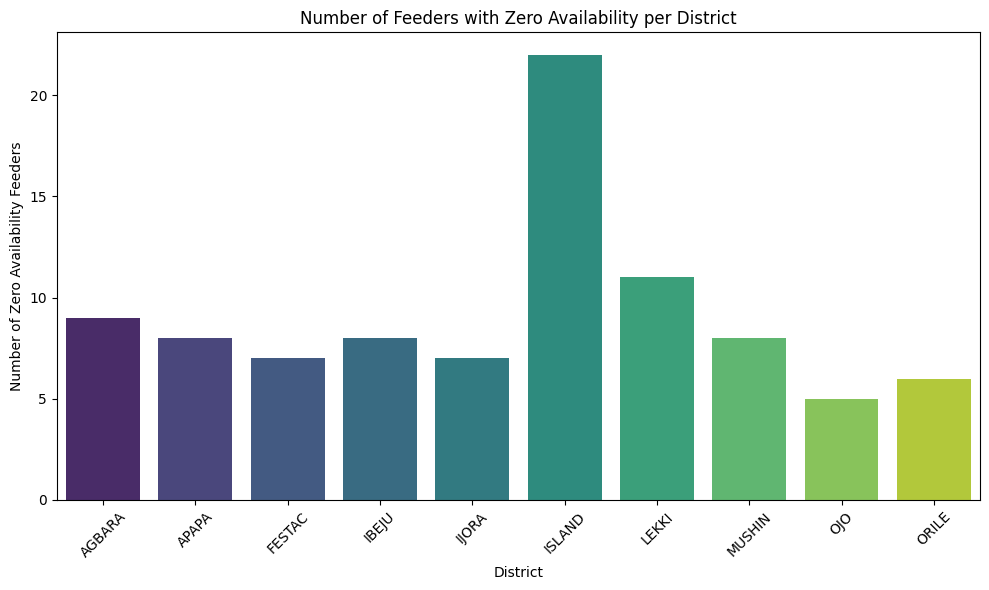

In [32]:
# Bar plot for number of zero availability feeders per district
plt.figure(figsize=(10,6))
sns.barplot(data=zero_avail_count, x='district', y='num_zero_avail_feeders', hue= 'district', palette='viridis')
plt.title('Number of Feeders with Zero Availability per District')
plt.xlabel('District')
plt.ylabel('Number of Zero Availability Feeders')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [33]:
# # --- Plot total zero availability feeders over time for all districts ---
# plt.figure(figsize=(16,7))
# sns.lineplot(data=zero_avail_count, x='date', y='num_zero_avail_feeders', hue='district', style='district', markers=True)
# plt.title('Number of Feeders with Zero Availability per Day Across Districts')
# plt.xlabel('Date')
# plt.ylabel('Number of Feeders with Zero Availability')
# plt.legend(title='District / Month', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
# plt.show()

##### To check for Load Shedding

In [34]:
# Calculate the average consumption of these feeders per district and day
avg_consumption_zero_avail = zero_avail.groupby(['district', 'date'])['consumption_mwh'] \
                                       .mean().reset_index(name='avg_consumption_mwh')

avg_consumption_zero_avail

district       date  avg_consumption_mwh
0      AGBARA 2019-01-01                  0.0
1      AGBARA 2019-01-02                  0.0
2      AGBARA 2019-01-03                  0.0
3      AGBARA 2019-01-08                  0.0
4      AGBARA 2019-01-09                  0.0
...       ...        ...                  ...
7779    ORILE 2021-10-04                  0.0
7780    ORILE 2021-10-05                  0.0
7781    ORILE 2021-10-06                  0.0
7782    ORILE 2021-10-07                  0.0
7783    ORILE 2021-10-27                  0.0

[7784 rows x 3 columns]

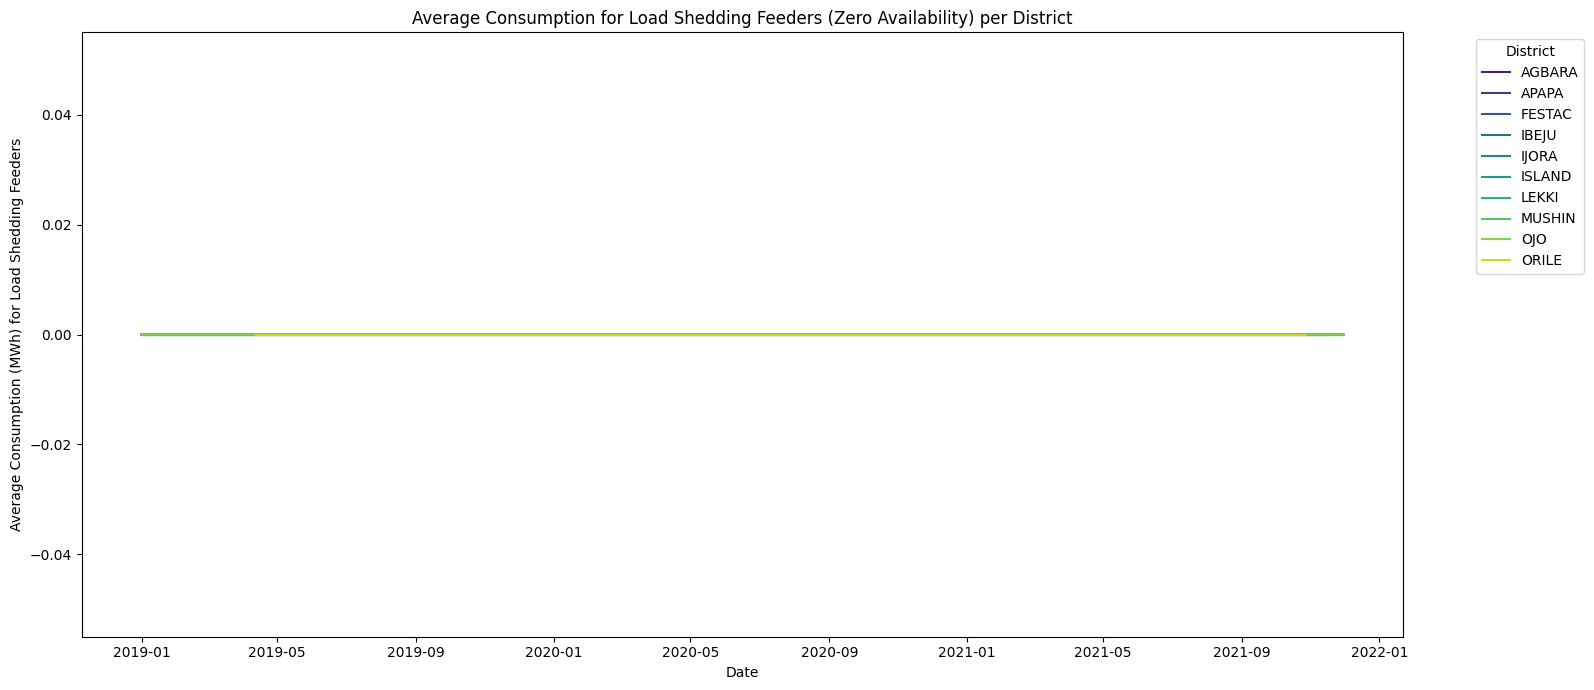

In [35]:
plt.figure(figsize=(16,7))
sns.lineplot(data=avg_consumption_zero_avail, 
             x='date', 
             y='avg_consumption_mwh', 
             hue='district', 
             markers=True, 
             palette='viridis')

# Add titles and labels
plt.title('Average Consumption for Load Shedding Feeders (Zero Availability) per District')
plt.xlabel('Date')
plt.ylabel('Average Consumption (MWh) for Load Shedding Feeders')
plt.legend(title='District', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

It seems there was no direct load shedding, then let's check for the average recovery time taken for each feeders to have power supply after non-availability

#### Average Recovery Time for District and Feeders

In [36]:
# Recovery time analysis (feeders with zero availability that still has consumption values)
zero_avail_feeders = zero_avail[['district', '33kv_feeder', 'date']].copy()
zero_avail_feeders.rename(columns={'date': 'date_zero'}, inplace=True)

consumption_positive = df_merged[df_merged['consumption_mwh'] > 0][['district', '33kv_feeder', 'date']].copy()
consumption_positive.rename(columns={'date': 'date_later'}, inplace=True)


In [37]:
# Merge zero availability feeders with positive consumption later
recovery = pd.merge(zero_avail_feeders, consumption_positive,
                    on=['district', '33kv_feeder'],
                    how='inner')

recovery

district 33kv_feeder  date_zero date_later
0          APAPA  NAVAL BASE 2019-01-01 2019-07-01
1          APAPA  NAVAL BASE 2019-01-01 2019-07-02
2          APAPA  NAVAL BASE 2019-01-01 2019-07-03
3          APAPA  NAVAL BASE 2019-01-01 2019-07-04
4          APAPA  NAVAL BASE 2019-01-01 2019-07-05
...          ...         ...        ...        ...
4829749      OJO  VOLKSWAGEN 2021-11-30 2020-05-02
4829750      OJO  VOLKSWAGEN 2021-11-30 2020-05-03
4829751      OJO  VOLKSWAGEN 2021-11-30 2020-05-04
4829752      OJO  VOLKSWAGEN 2021-11-30 2020-05-05
4829753      OJO  VOLKSWAGEN 2021-11-30 2020-05-06

[4829754 rows x 4 columns]

In [38]:
# Filter where consumption happens after zero availability date
recovery = recovery[recovery['date_later'] > recovery['date_zero']]
recovery.loc[:, 'recovery_time'] = (recovery['date_later'] - recovery['date_zero']).dt.days

C:\Users\pc\AppData\Local\Temp\ipykernel_20328\3605602439.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recovery.loc[:, 'recovery_time'] = (recovery['date_later'] - recovery['date_zero']).dt.days


In [39]:
 #Average recovery time per district
avg_recovery_district = recovery.groupby('district')['recovery_time'].mean().reset_index(name='avg_recovery_time_days')
avg_recovery_district

district  avg_recovery_time_days
0   AGBARA              365.730581
1    APAPA              324.572766
2   FESTAC              360.177500
3    IBEJU              322.482808
4    IJORA              480.822336
5   ISLAND              390.701665
6    LEKKI              514.615032
7   MUSHIN              375.515066
8      OJO              354.959449
9    ORILE              330.457138

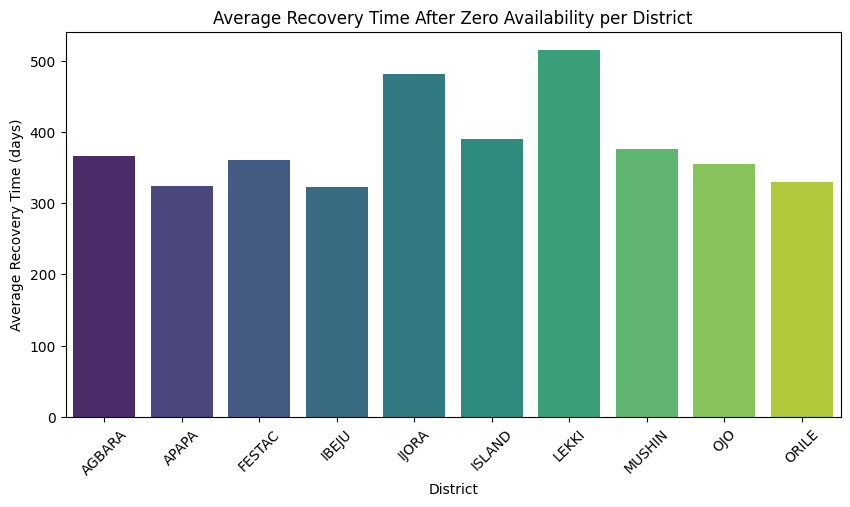

In [40]:
# Plot average recovery time per district
plt.figure(figsize=(10,5))
sns.barplot(data=avg_recovery_district, x='district', y='avg_recovery_time_days', hue='district', palette='viridis')
plt.title('Average Recovery Time After Zero Availability per District')
plt.ylabel('Average Recovery Time (days)')
plt.xlabel('District')
plt.xticks(rotation=45)
plt.show()

In [41]:
# Average recovery time by feeder across all districts
avg_recovery_feeder = recovery.groupby(['district', '33kv_feeder'])['recovery_time'] \
                             .mean().reset_index(name='avg_recovery_time_days')
                             

avg_recovery_feeder

# print("\nAverage Recovery Time by Feeder:")
# print(avg_recovery_feeder.sort_values(['district', 'avg_recovery_time_days']).head(10))

district      33kv_feeder  avg_recovery_time_days
0    AGBARA        AGBARA 33              397.181902
1    AGBARA  AGBARA LOCAL T4              293.887388
2    AGBARA  AGBARA LOCAL T5              361.794624
3    AGBARA  AGBARA LOCAL T6              292.518998
4    AGBARA       BADAGRY 33              395.652059
..      ...              ...                     ...
85    ORILE        ADELABU 2              360.693593
86    ORILE            AMUWO              369.932194
87    ORILE         IGANMU 1              373.828265
88    ORILE         IGANMU 2              257.486399
89    ORILE         SANYA 33              275.617873

[90 rows x 3 columns]

In [42]:
# Count of zero availability feeders by district and date
zero_avail_summary = zero_avail.groupby(['district', 'date'])['33kv_feeder'] \
                              .nunique().reset_index(name='zero_avail_feeder_count')

zero_avail_summary
# print("Zero Availability Feeders Count by District and Date:")
# print(zero_avail_summary)

district       date  zero_avail_feeder_count
0      AGBARA 2019-01-01                        1
1      AGBARA 2019-01-02                        2
2      AGBARA 2019-01-03                        1
3      AGBARA 2019-01-08                        1
4      AGBARA 2019-01-09                        1
...       ...        ...                      ...
7779    ORILE 2021-10-04                        1
7780    ORILE 2021-10-05                        1
7781    ORILE 2021-10-06                        1
7782    ORILE 2021-10-07                        1
7783    ORILE 2021-10-27                        1

[7784 rows x 3 columns]

C:\Users\pc\AppData\Local\Temp\ipykernel_20328\1874310383.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=avg_recovery_feeder, x='33kv_feeder', y='avg_recovery_time_days', palette='viridis')


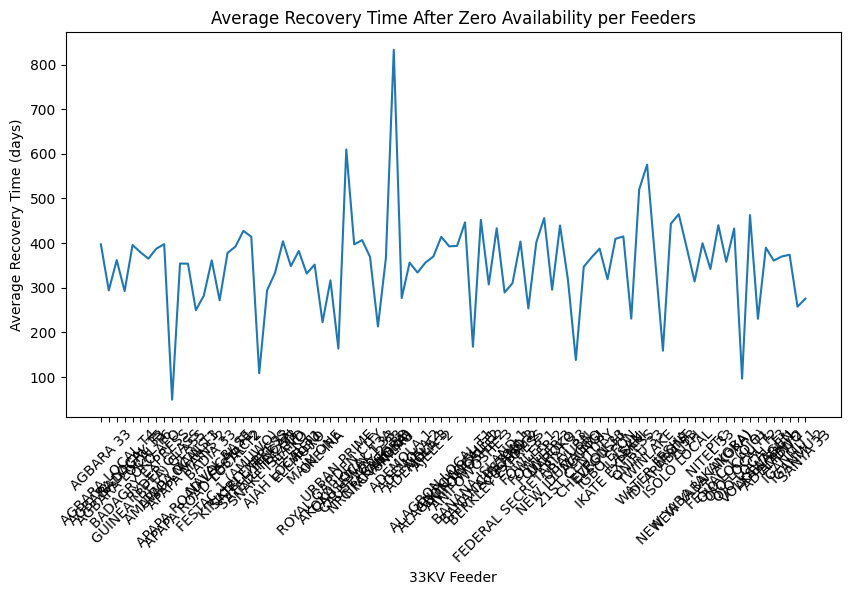

In [43]:
# Plot average recovery time per district
plt.figure(figsize=(10,5))
sns.lineplot(data=avg_recovery_feeder, x='33kv_feeder', y='avg_recovery_time_days', palette='viridis')
plt.title('Average Recovery Time After Zero Availability per Feeders')
plt.ylabel('Average Recovery Time (days)')
plt.xlabel('33KV Feeder')
plt.xticks(rotation=45)
plt.show()

### Critical Data Analysis

In [44]:
#filter the data to only two districts which are Apapa and Ijora and then delete the circle column
df_filtered = df_merged[df_merged['district'].isin(['APAPA', 'IJORA'])].drop(columns=['circle'])

#Plot each feeders separately one by one with the date on the x-axis and both availability_hrs and consumption_mwh on the y-axis
def plot_feeder_data(df, feeder_name):
    feeder_data = df[df['33kv_feeder'] == feeder_name]
    district = feeder_data['district'].iloc[0]
    
    plt.figure(figsize=(14, 7))
    sns.lineplot(data=feeder_data, x='date', y='availability_hrs', label='Availability Hours', color='blue')
    sns.lineplot(data=feeder_data, x='date', y='consumption_mwh', label='Consumption (MWh)', color='orange')
    
    plt.title(f'{district} [{feeder_name} Feeder]: Availability and Consumption Over Time')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [45]:
df_filtered

date district          33kv_feeder  availability_hrs  \
0     2019-01-01    APAPA       AMUWO LOCAL T3              24.0   
1     2019-01-01    APAPA        APAPA MAINS 1              24.0   
2     2019-01-01    APAPA        APAPA MAINS 2              24.0   
3     2019-01-01    APAPA  APAPA ROAD LOCAL T1              21.0   
4     2019-01-01    APAPA  APAPA ROAD LOCAL T2              24.0   
...          ...      ...                  ...               ...   
94309 2021-11-30    IJORA        CAUSEWAY 1 33              12.0   
94310 2021-11-30    IJORA        CAUSEWAY 2 33              10.0   
94311 2021-11-30    IJORA        NRC (AKANGBA)              24.0   
94312 2021-11-30    IJORA              SABO 33              23.0   
94313 2021-11-30    IJORA               UNILAG              24.0   

       consumption_mwh  
0                191.0  
1                 75.0  
2                 22.0  
3                135.3  
4                192.3  
...                ...  
94309             56.9  
94310             60.7  
94311            229.3  
94312            169.0  
94313             86.0  

[15974 rows x 5 columns]

In [46]:
#Check for unique feeders in Apapa district
df_filtered[df_filtered["district"]== "APAPA"]["33kv_feeder"].unique()

array(['AMUWO LOCAL T3', 'APAPA MAINS 1', 'APAPA MAINS 2',
       'APAPA ROAD LOCAL T1', 'APAPA ROAD LOCAL T2', 'BADIA 33',
       'FLOUR MILLS', 'NAVAL BASE'], dtype=object)

Plot for APAPA District

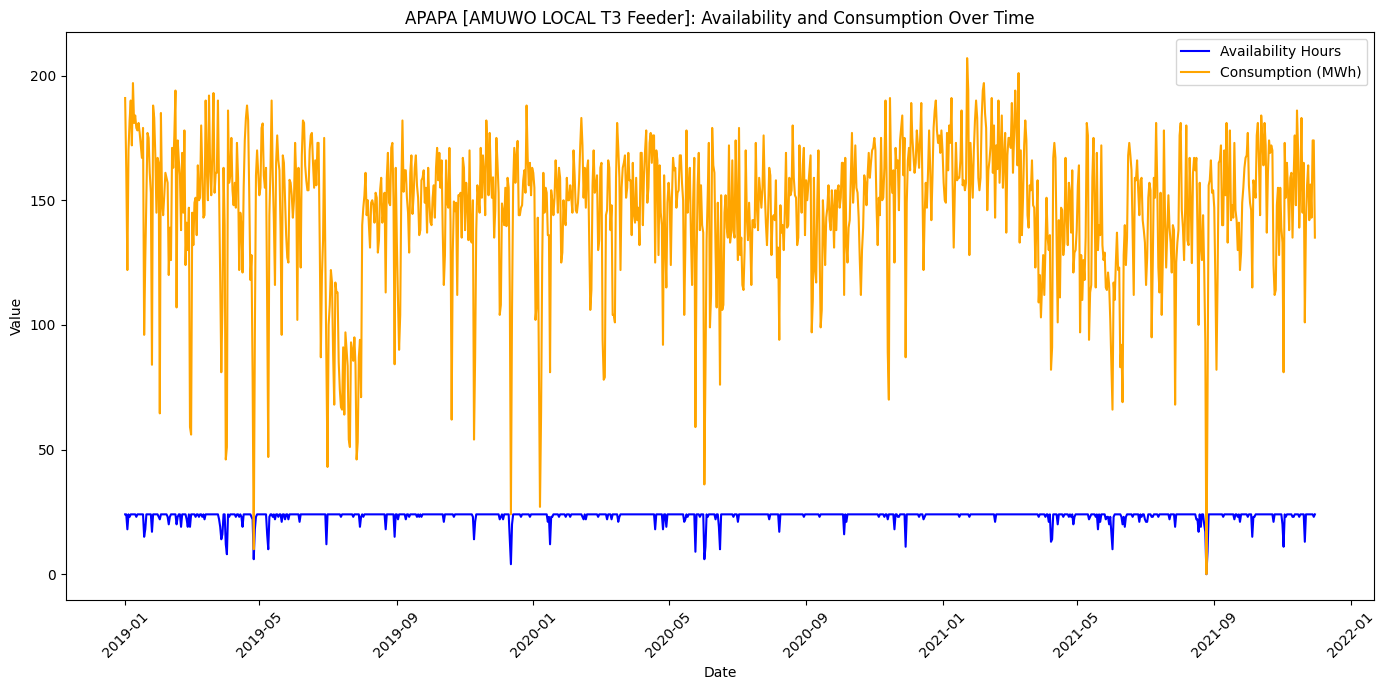

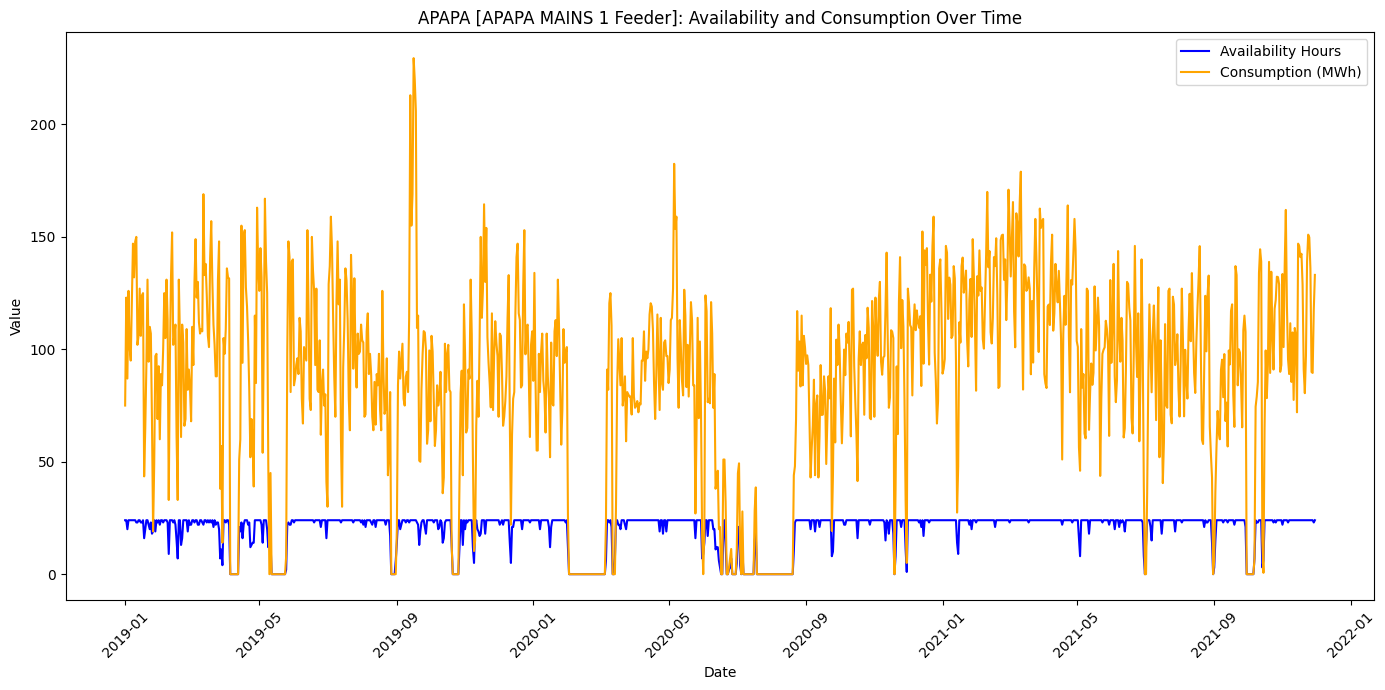

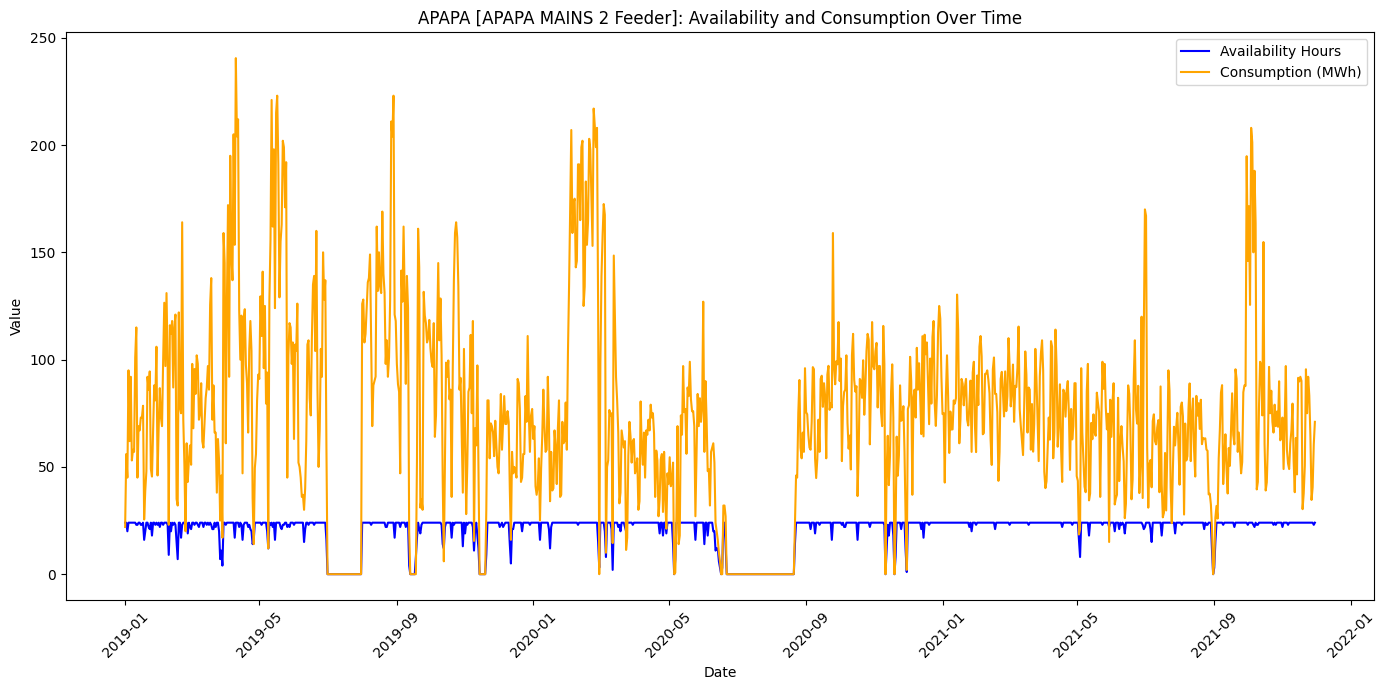

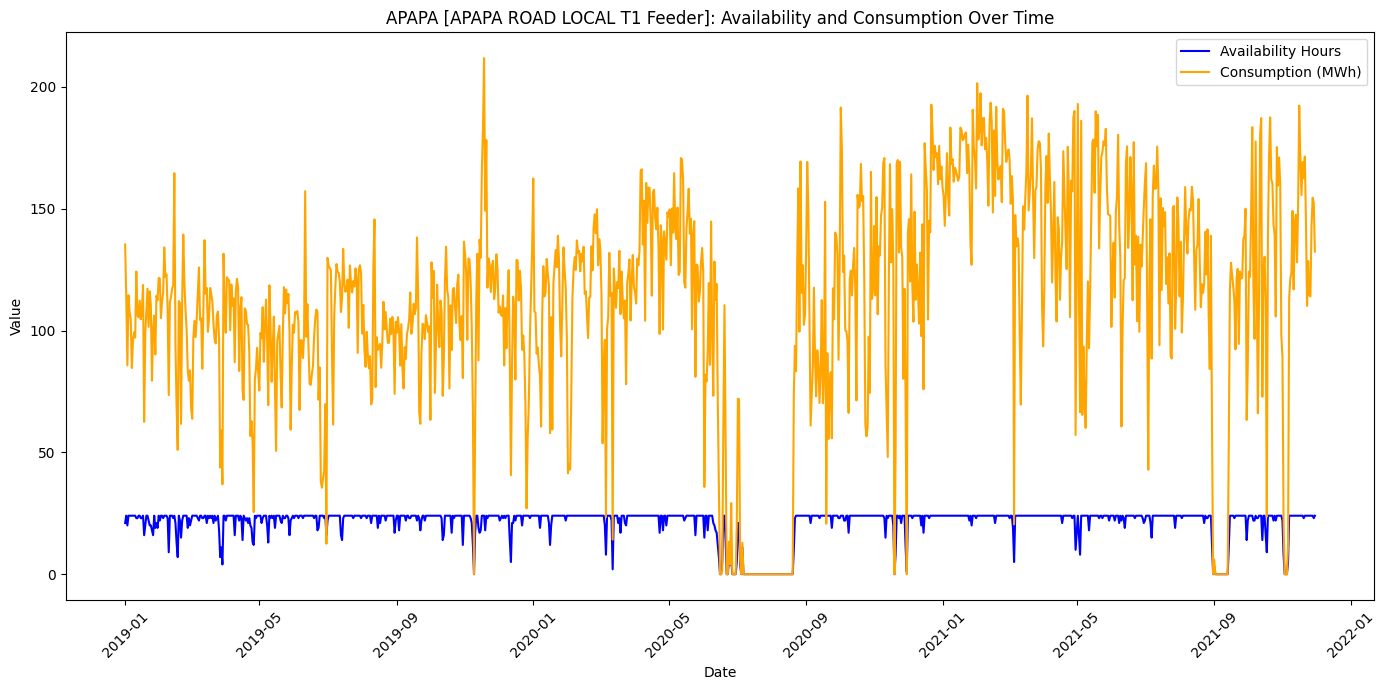

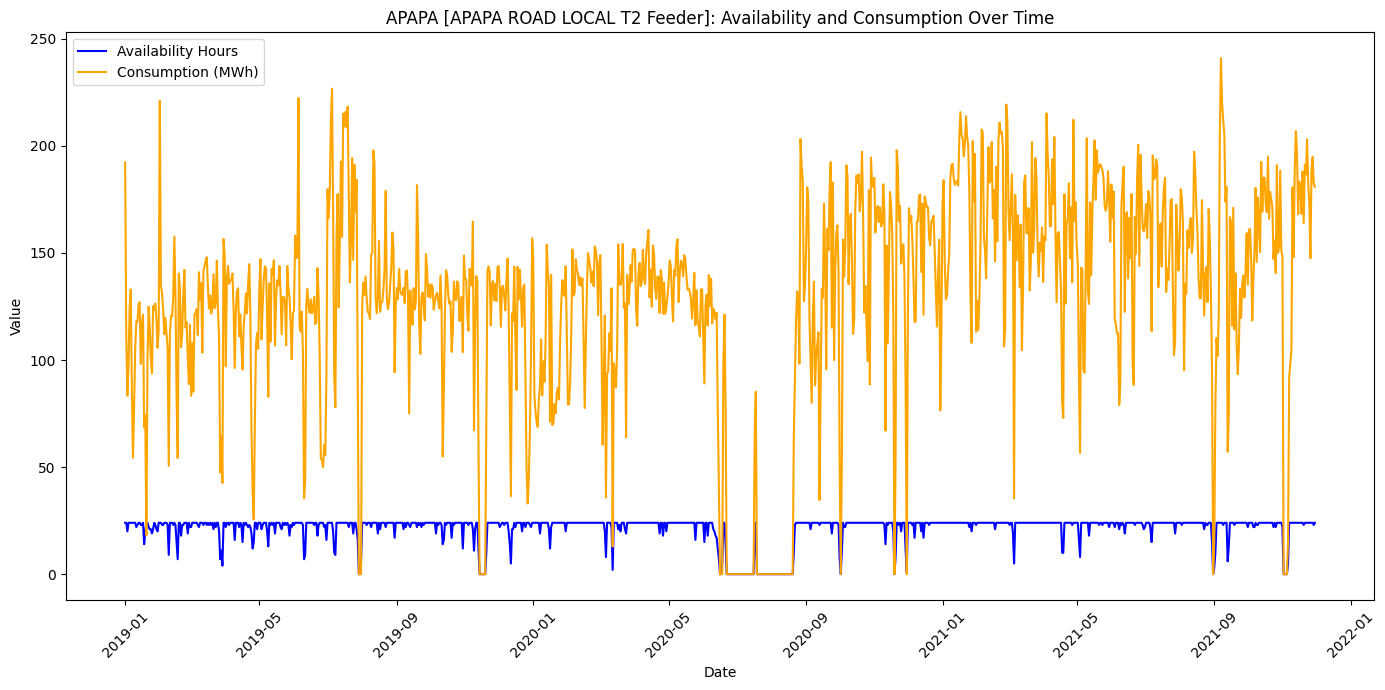

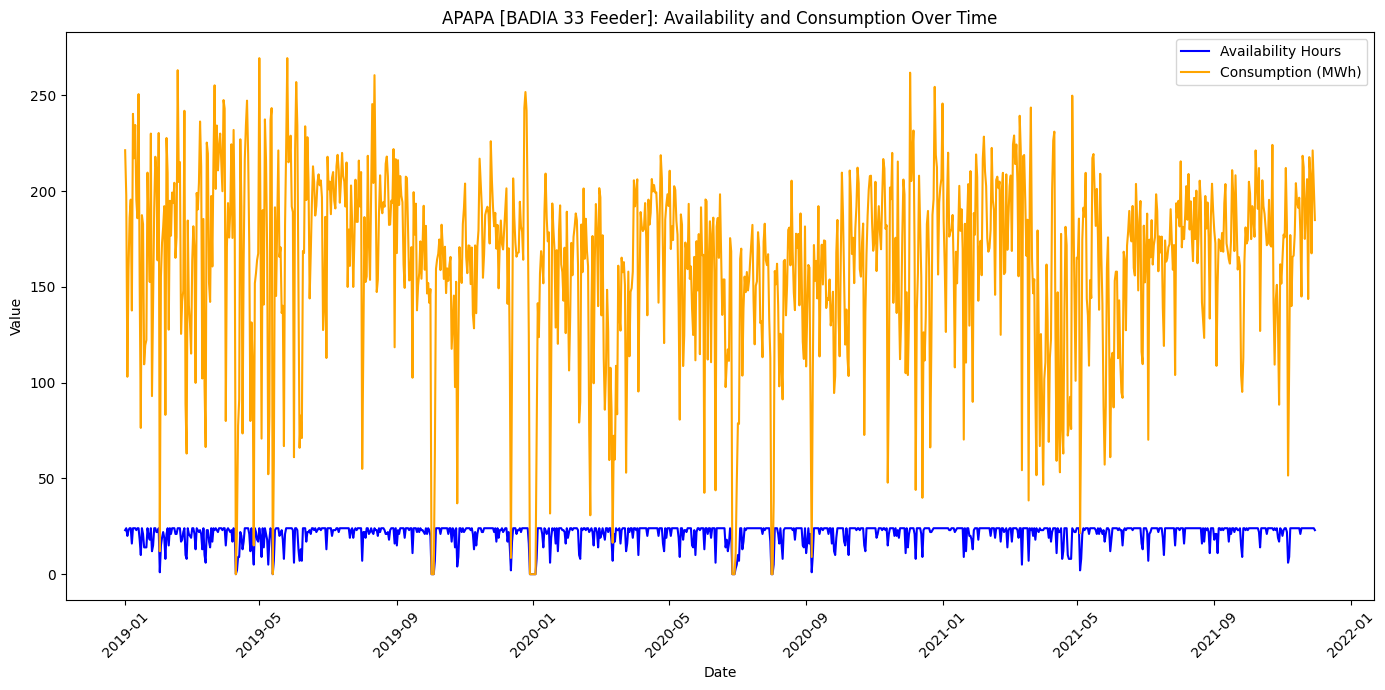

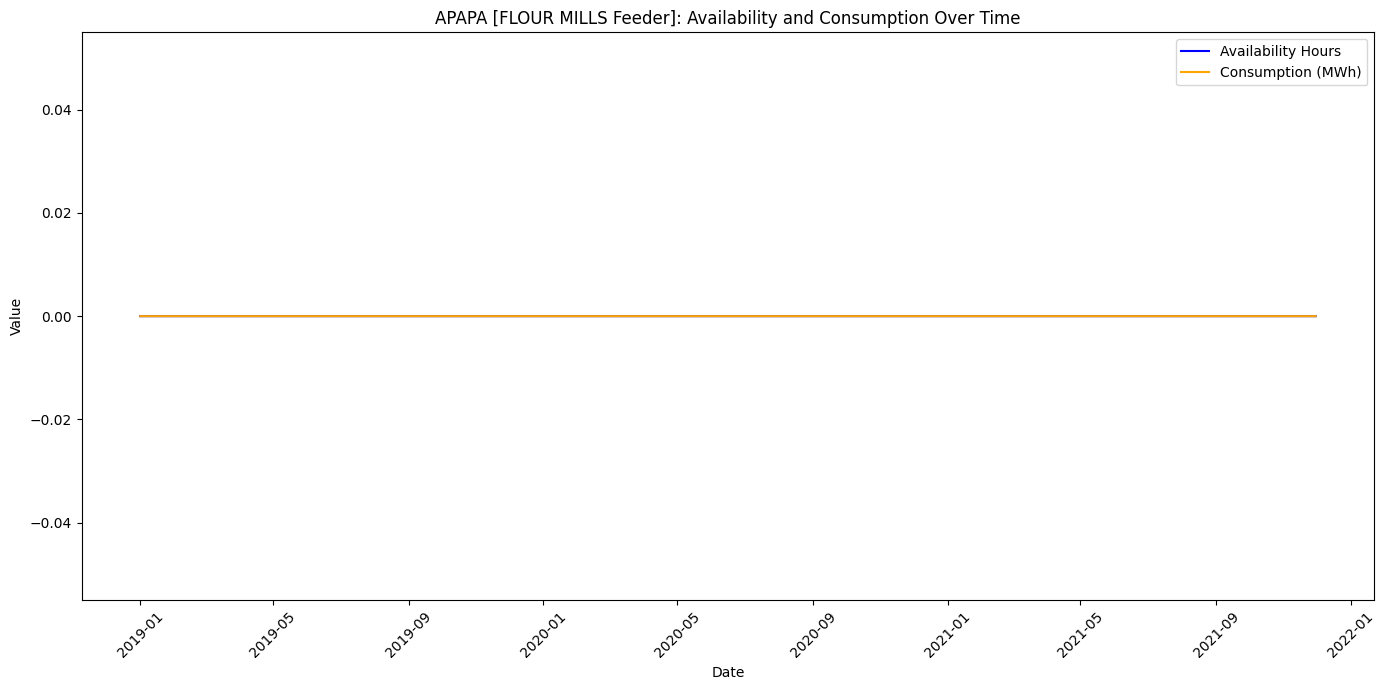

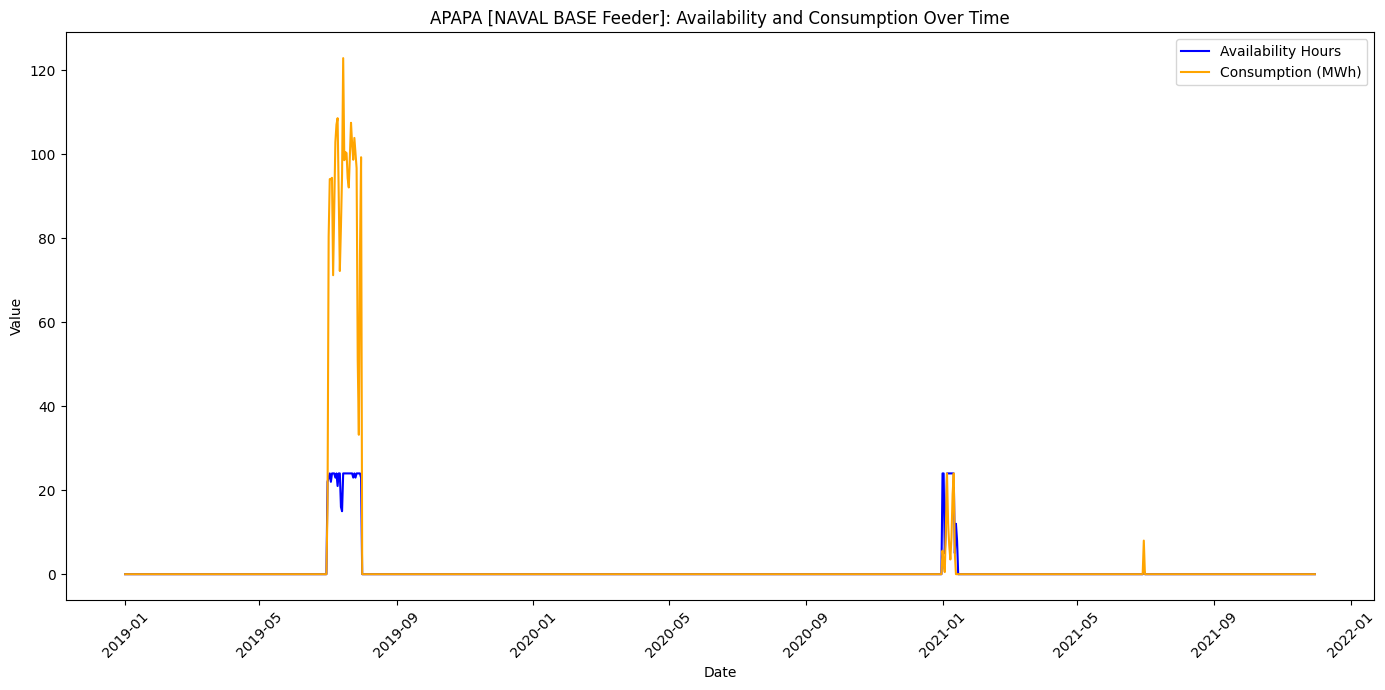

In [47]:
#Plot for AMUWO LOCAL T3
plot_feeder_data(df_filtered, 'AMUWO LOCAL T3')
#Plot for APAPA MAINS 1
plot_feeder_data(df_filtered, 'APAPA MAINS 1')

#Plot for APAPA MAINS 2
plot_feeder_data(df_filtered, 'APAPA MAINS 2')

#Plot for APAPA ROAD LOCAL T1
plot_feeder_data(df_filtered, 'APAPA ROAD LOCAL T1')

# Plot for APAPA ROAD LOCAL T2
plot_feeder_data(df_filtered, 'APAPA ROAD LOCAL T2')

#Plot for BADIA 33
plot_feeder_data(df_filtered, 'BADIA 33')


#Plot for FLOUR MILLS
plot_feeder_data(df_filtered, 'FLOUR MILLS')

# Plot for Naval Base
plot_feeder_data(df_filtered, 'NAVAL BASE') 

In [48]:
df_filtered

date district          33kv_feeder  availability_hrs  \
0     2019-01-01    APAPA       AMUWO LOCAL T3              24.0   
1     2019-01-01    APAPA        APAPA MAINS 1              24.0   
2     2019-01-01    APAPA        APAPA MAINS 2              24.0   
3     2019-01-01    APAPA  APAPA ROAD LOCAL T1              21.0   
4     2019-01-01    APAPA  APAPA ROAD LOCAL T2              24.0   
...          ...      ...                  ...               ...   
94309 2021-11-30    IJORA        CAUSEWAY 1 33              12.0   
94310 2021-11-30    IJORA        CAUSEWAY 2 33              10.0   
94311 2021-11-30    IJORA        NRC (AKANGBA)              24.0   
94312 2021-11-30    IJORA              SABO 33              23.0   
94313 2021-11-30    IJORA               UNILAG              24.0   

       consumption_mwh  
0                191.0  
1                 75.0  
2                 22.0  
3                135.3  
4                192.3  
...                ...  
94309             56.9  
94310             60.7  
94311            229.3  
94312            169.0  
94313             86.0  

[15974 rows x 5 columns]

In [49]:
df_filtered.shape

(15974, 5)

In [50]:
df_filtered[df_filtered['district'] == 'IJORA']['33kv_feeder'].unique()

array(['NRC (AKOKA)', 'AKOKA LOCAL T3A', 'CAUSEWAY 1 33', 'CAUSEWAY 2 33',
       'NRC (AKANGBA)', 'SABO 33', 'UNILAG'], dtype=object)

Plot for IJORA

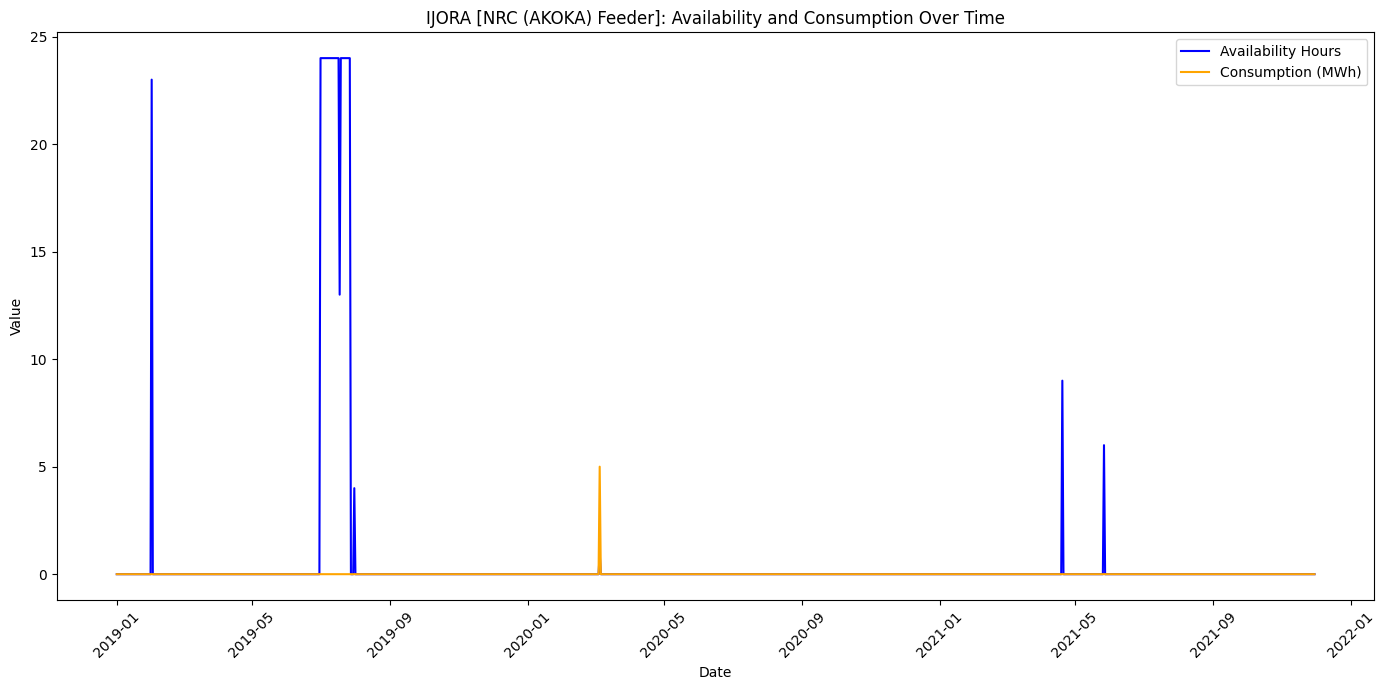

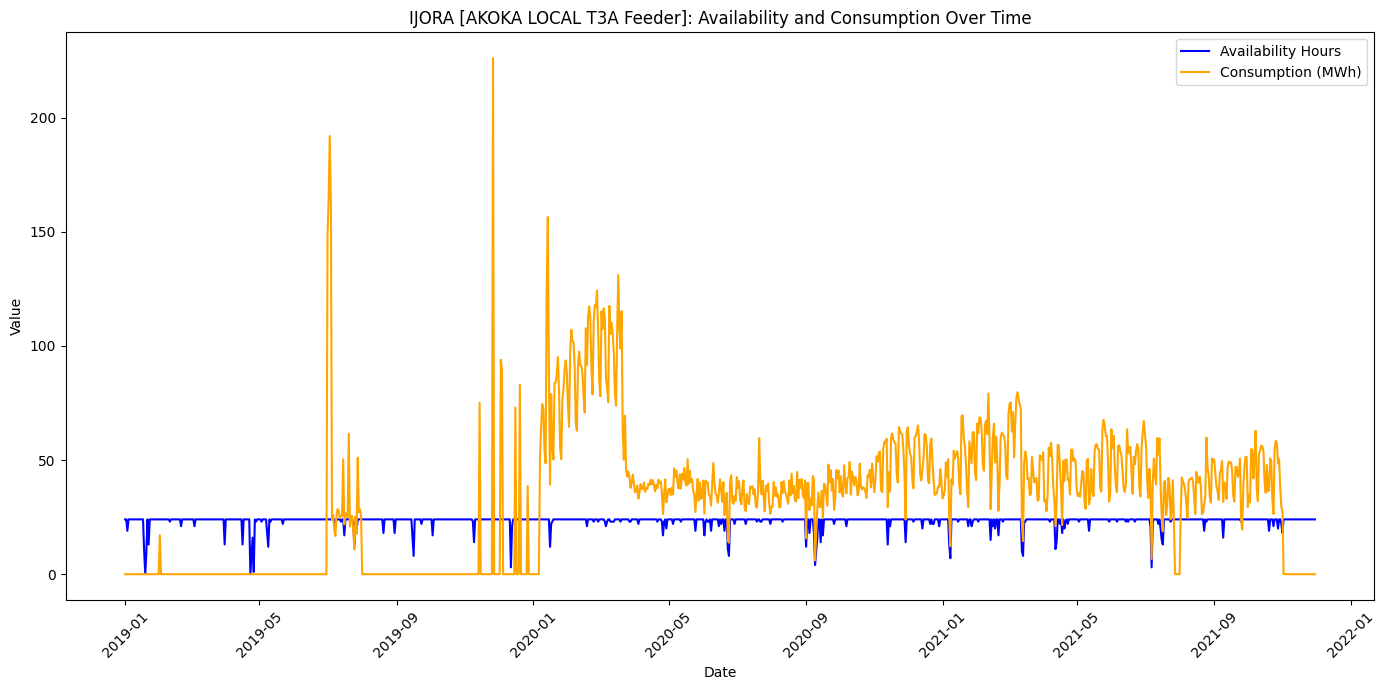

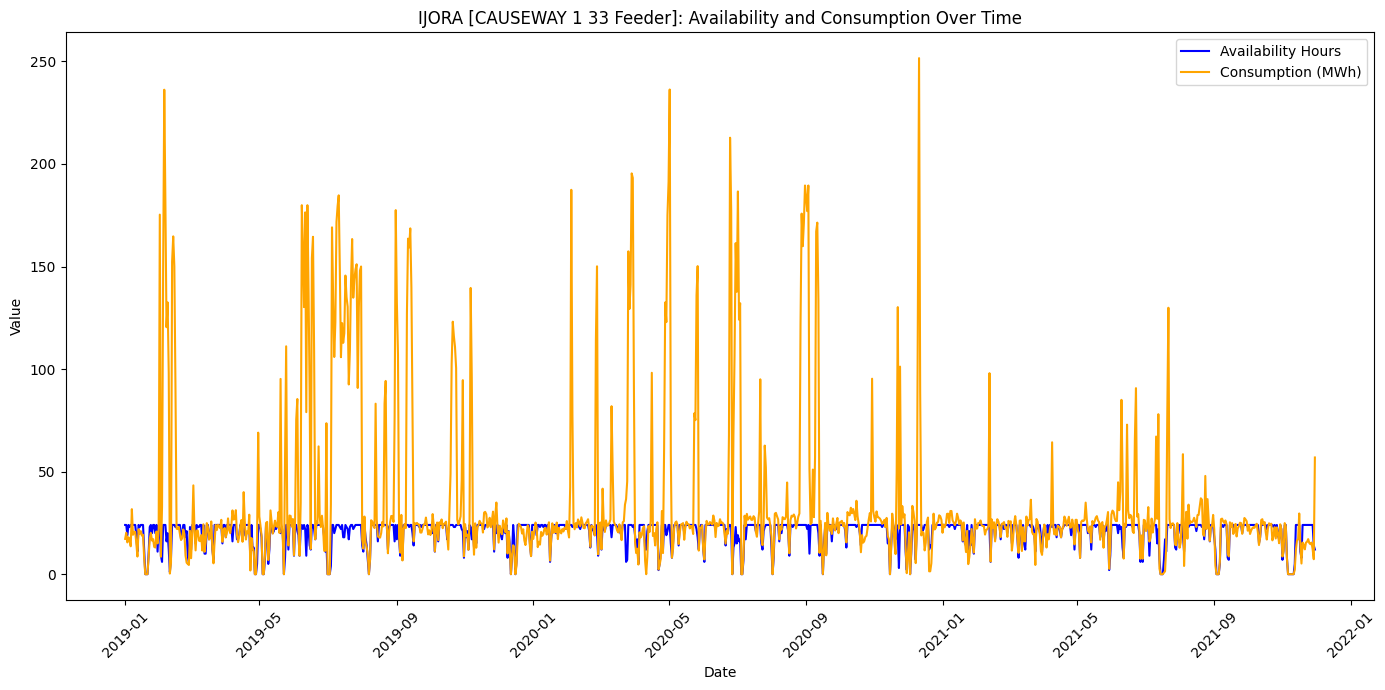

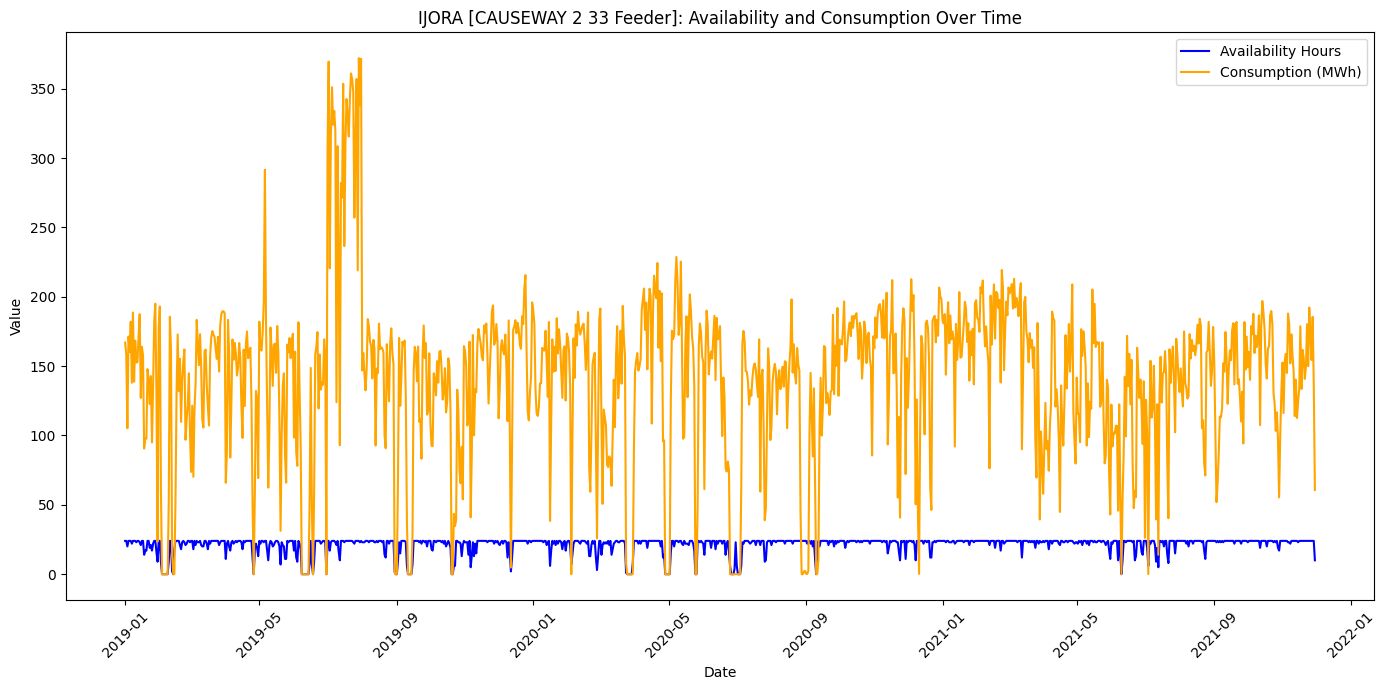

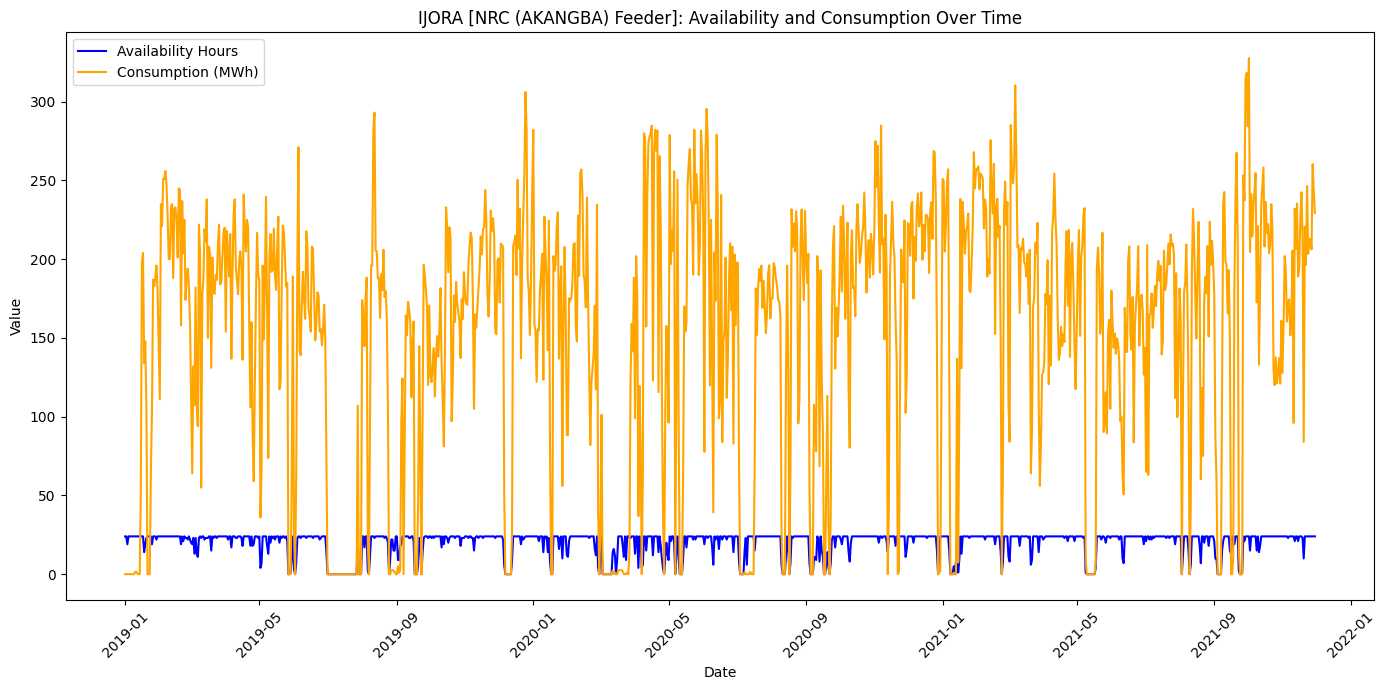

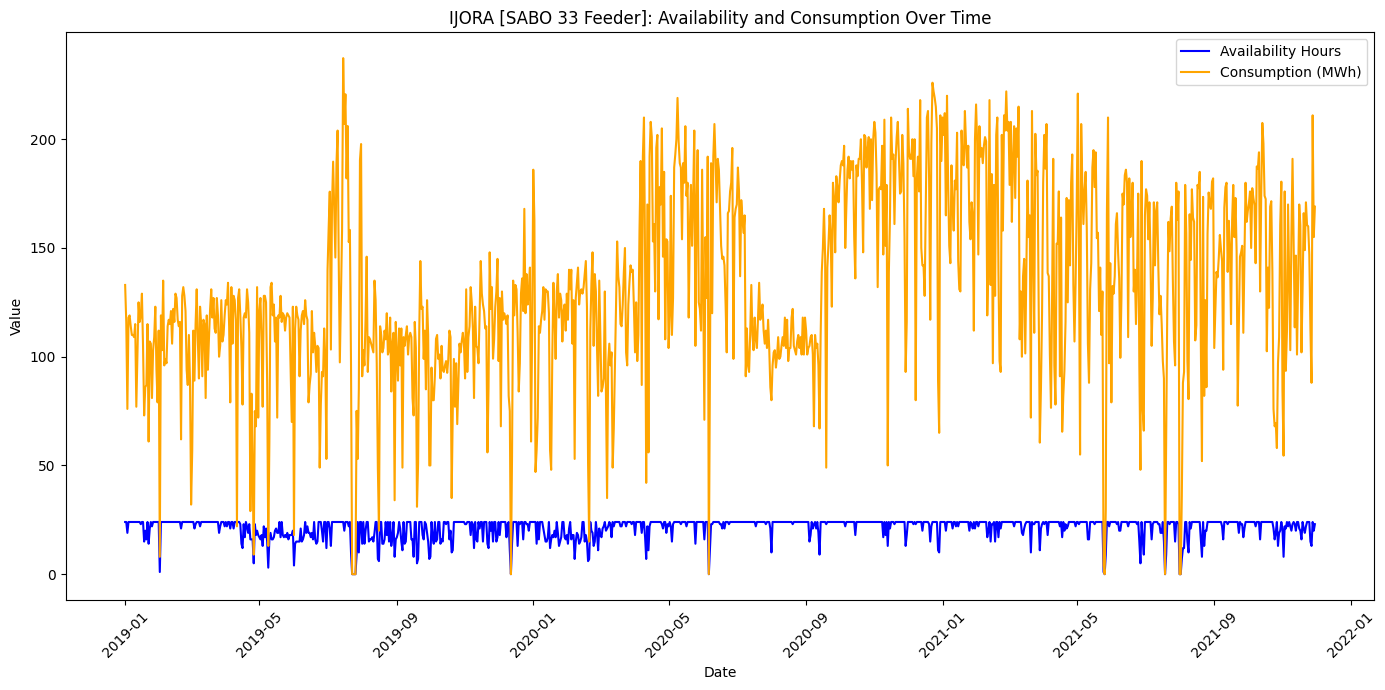

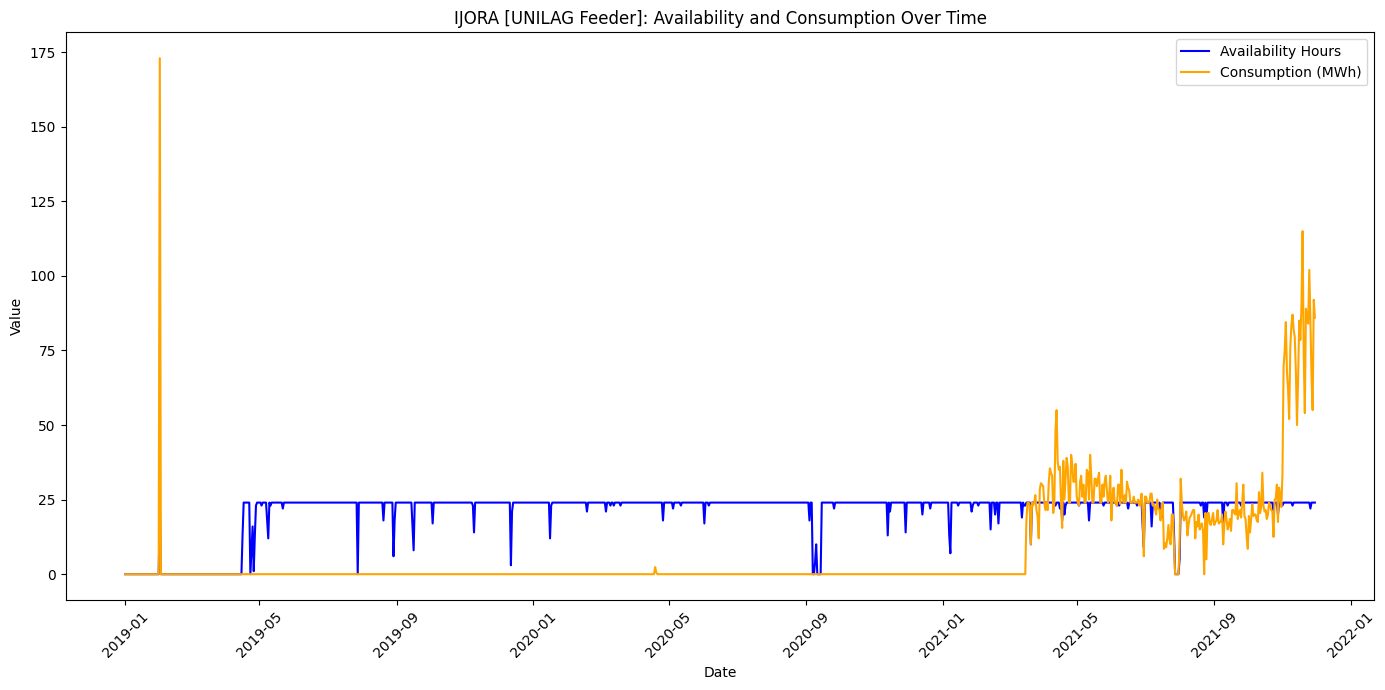

In [51]:
#Plot for NRC (AKOKA)
plot_feeder_data(df_filtered, 'NRC (AKOKA)')

#Plot for AKOKA LOCAL T3A
plot_feeder_data(df_filtered, 'AKOKA LOCAL T3A')

#Plot for CAUSEWAY 1 33
plot_feeder_data(df_filtered, 'CAUSEWAY 1 33')

#Plot for CAUSEWAY 2 33
plot_feeder_data(df_filtered, 'CAUSEWAY 2 33')

#Plot for NRC (AKANGBA)
plot_feeder_data(df_filtered, 'NRC (AKANGBA)')

#Plot for SABO 33
plot_feeder_data(df_filtered, 'SABO 33')

#Plot for UNILAG
plot_feeder_data(df_filtered, 'UNILAG')

In [52]:
#plot function that stacks up all the feeders using subplots 
def plot_feeders_in_district(df, district_name):
    feeders = df[df['district'] == district_name]['33kv_feeder'].unique()
    
    num_feed = len(feeders)
    fig, axes = plt.subplots(num_feed, 1, figsize=(14, 5 * num_feed), sharex=True)
    
    for i, feeder in enumerate(feeders):
        feeder_data = df[df['33kv_feeder'] == feeder]
        
        sns.lineplot(data=feeder_data, x='date', y='availability_hrs', ax=axes[i], label='Availability Hours', color='blue')
        sns.lineplot(data=feeder_data, x='date', y='consumption_mwh', ax=axes[i], label='Consumption (MWh)', color='orange')
        
        axes[i].set_title(f'{feeder} - Availability and Consumption Over Time')
        axes[i].set_ylabel('Value')
        axes[i].legend()
    
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.suptitle(f'Feeders in {district_name}', fontsize=16, y=1.02)
    plt.show()

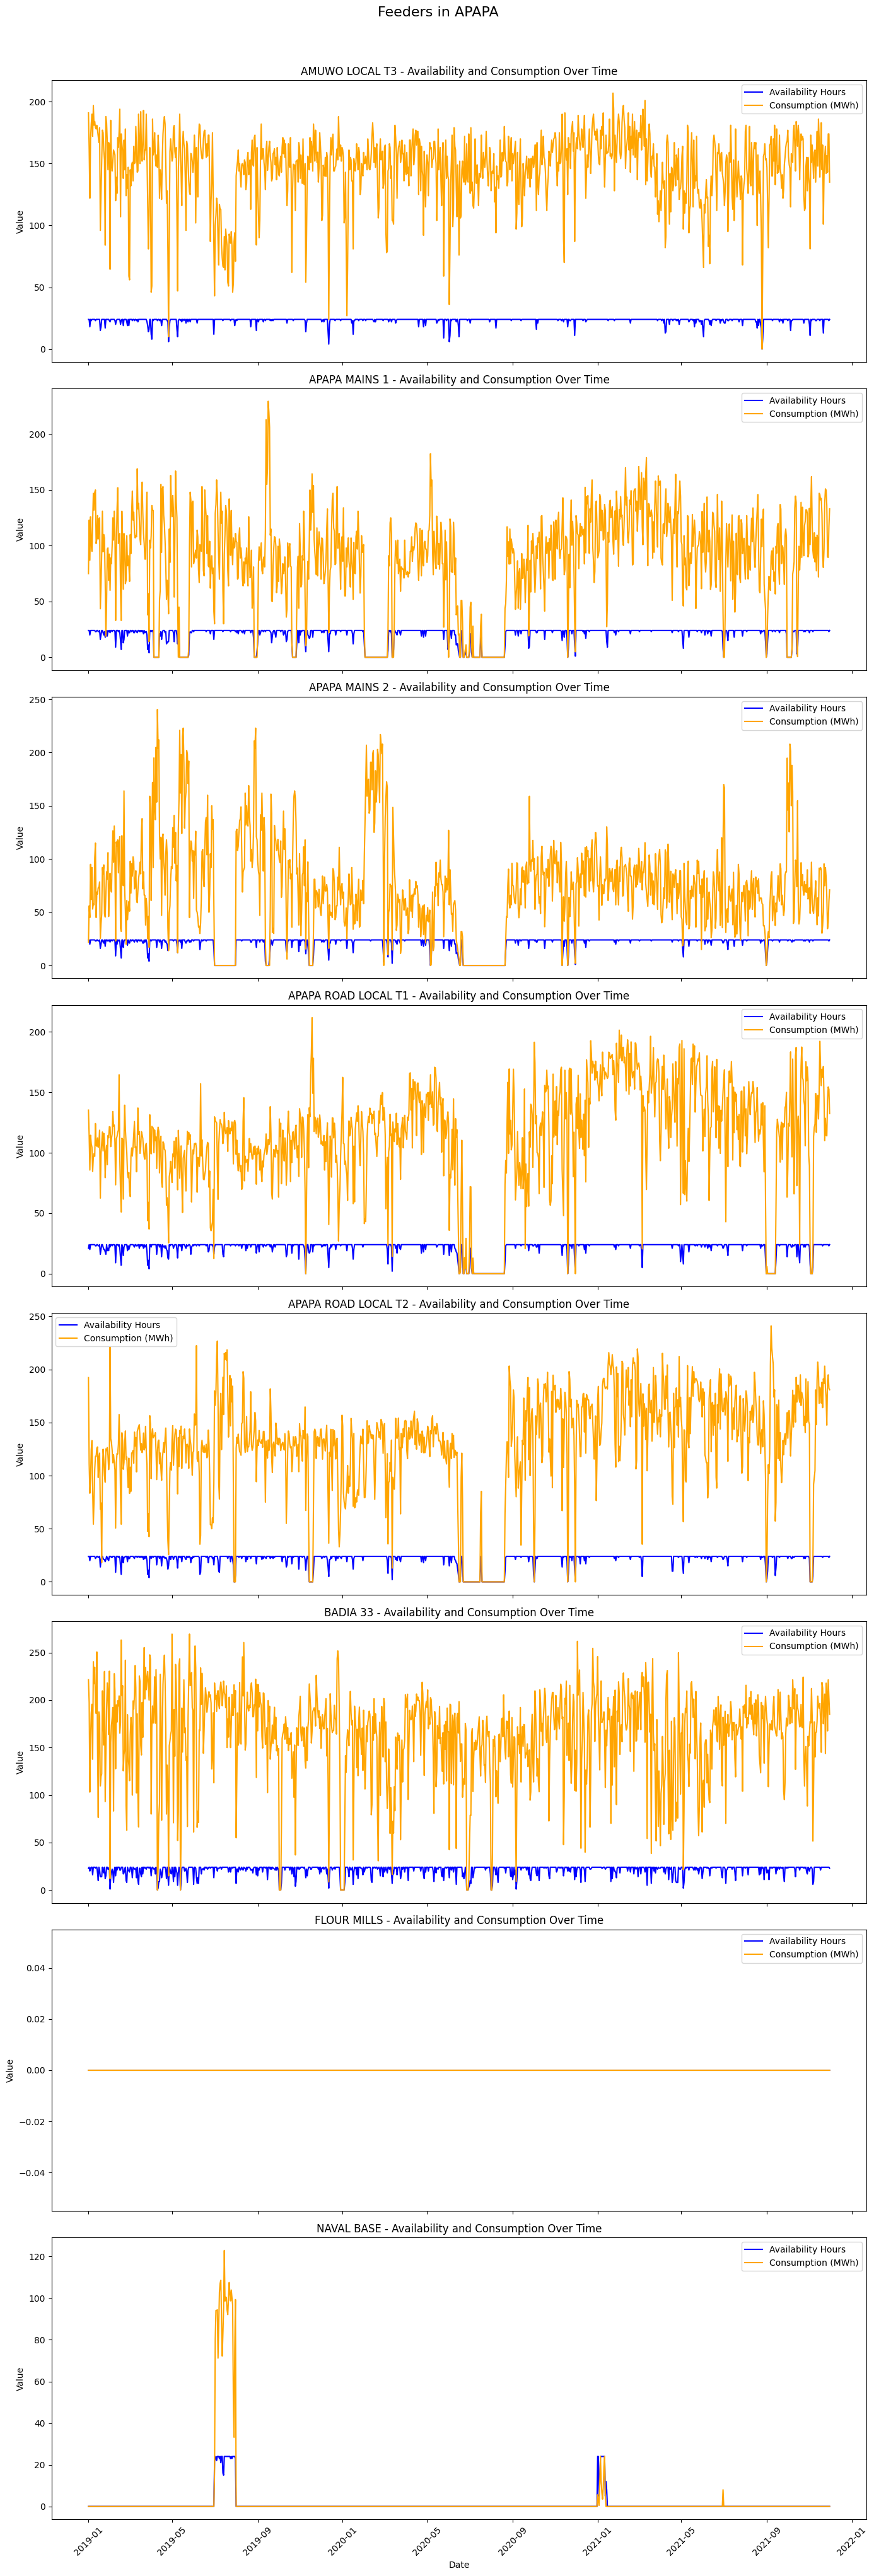

In [53]:
# Plot all feeders in APAPA district
plot_feeders_in_district(df_filtered, 'APAPA')

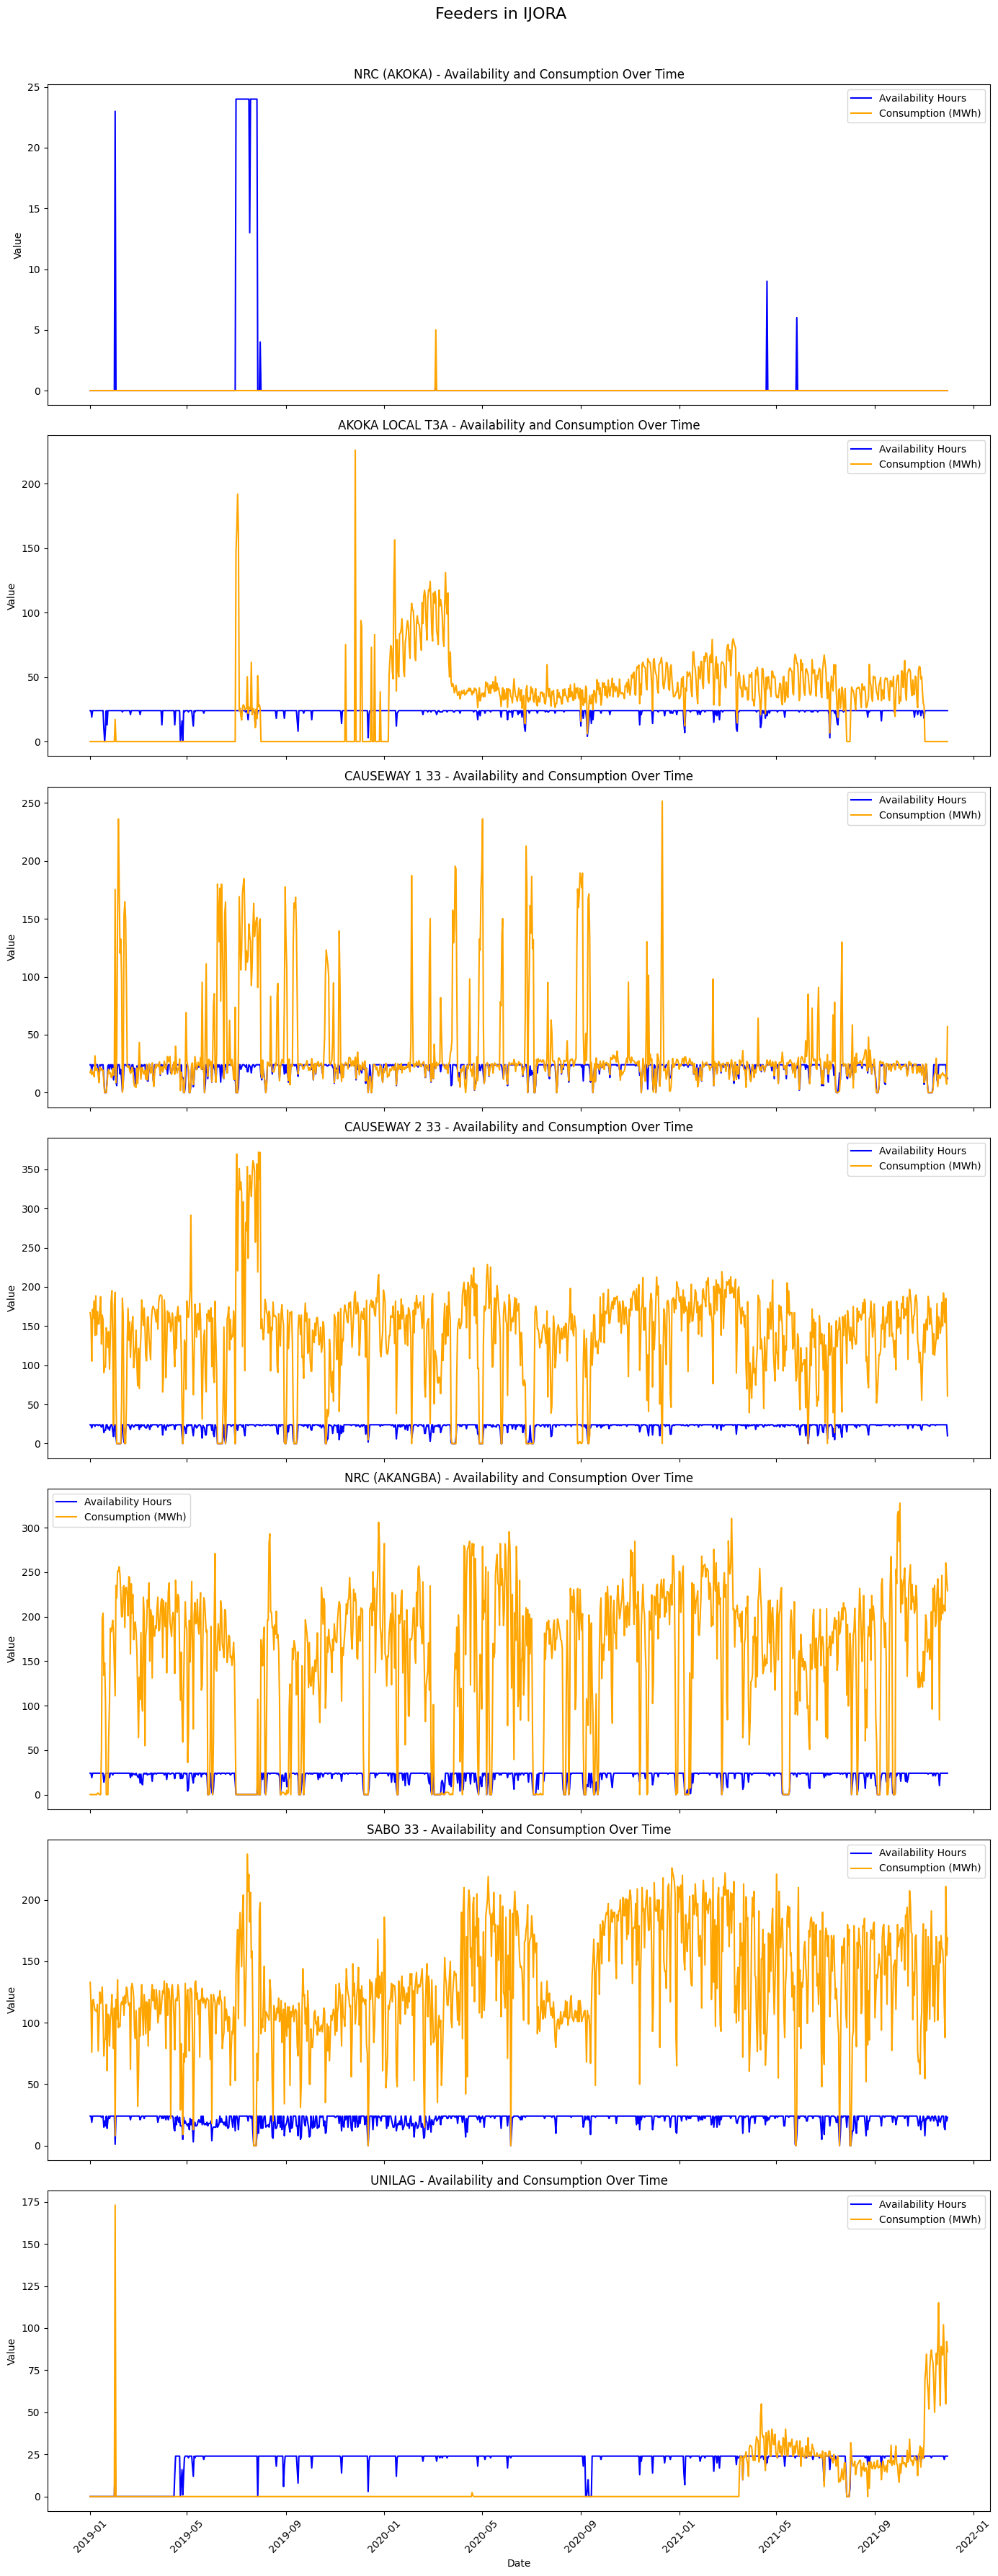

In [54]:
plot_feeders_in_district(df_filtered, 'IJORA')

### Feature Engineering

In [55]:
# Create dataframe that comprise the consumption for each of the 15 feeders (in all the districts)
def feeder_consumption_df(df):
    # Pivot the table: rows are dates, columns are feeders, values are mean consumption
    consumption_df = df.pivot_table(
        index='date',
        columns='33kv_feeder',
        values='consumption_mwh',
        aggfunc='mean'
    ).reset_index()
    return consumption_df

In [56]:
feeder_cons_df = feeder_consumption_df(df_filtered)
feeder_cons_df

33kv_feeder       date  AKOKA LOCAL T3A  AMUWO LOCAL T3  APAPA MAINS 1  \
0           2019-01-01              0.0           191.0           75.0   
1           2019-01-02              0.0           162.0          123.0   
2           2019-01-03              0.0           122.0           87.0   
3           2019-01-04              0.0           170.0          126.0   
4           2019-01-05              0.0           182.0          101.0   
...                ...              ...             ...            ...   
1060        2021-11-26              0.0           156.3          135.9   
1061        2021-11-27              0.0           143.0           89.9   
1062        2021-11-28              0.0           174.0           89.5   
1063        2021-11-29              0.0           174.0          117.5   
1064        2021-11-30              0.0           135.0          133.1   

33kv_feeder  APAPA MAINS 2  APAPA ROAD LOCAL T1  APAPA ROAD LOCAL T2  \
0                     22.0                135.3                192.3   
1                     56.0                113.8                111.3   
2                     45.0                 85.7                 83.4   
3                     95.0                114.5                 97.6   
4                     62.0                107.5                124.6   
...                    ...                  ...                  ...   
1060                  64.2                114.0                147.5   
1061                  34.6                143.3                189.8   
1062                  40.5                154.5                194.9   
1063                  60.5                152.5                182.2   
1064                  71.0                132.4                180.9   

33kv_feeder  BADIA 33  CAUSEWAY 1 33  CAUSEWAY 2 33  FLOUR MILLS  NAVAL BASE  \
0              221.40           17.2         167.00          0.0         0.0   
1              197.70           20.2         158.40          0.0         0.0   
2              103.10           15.5         105.20          0.0         0.0   
3              158.70           18.0         171.30          0.0         0.0   
4              186.30           16.4         160.10          0.0         0.0   
...               ...            ...            ...          ...         ...   
1060           208.20           14.6         171.21          0.0         0.0   
1061           167.56           15.4         154.40          0.0         0.0   
1062           221.30           12.1         185.50          0.0         0.0   
1063           202.30            7.3         137.10          0.0         0.0   
1064           184.93           56.9          60.70          0.0         0.0   

33kv_feeder  NRC (AKANGBA)  NRC (AKOKA)  SABO 33  UNILAG  
0                      0.0          0.0    133.0     0.0  
1                      0.0          0.0    116.0     0.0  
2                      0.0          0.0     76.0     0.0  
3                      0.0          0.0    118.0     0.0  
4                      0.0          0.0    119.0     0.0  
...                    ...          ...      ...     ...  
1060                 212.5          0.0    113.0    85.0  
1061                 206.3          0.0     88.0    66.0  
1062                 260.4          0.0    211.0    55.0  
1063                 243.1          0.0    155.0    92.0  
1064                 229.3          0.0    169.0    86.0  

[1065 rows x 16 columns]

In [57]:
# max_unilag= feeder_cons_df['UNILAG'].max()
# max_unilag

In [58]:
#Create max_energy deficit for each feeder
# Calculation is:
# max_energy_deficit = max of each feeder - the feeder consumption values
def energy_deficit_df(df):
    dates= df['date']
    feeders_df= df.drop(columns=['date'])
    max_values = feeders_df.max()
    energy_deficit = max_values - feeders_df
    #Add the date column back to the energy deficit DataFrame
    energy_deficit.insert(0, 'date', dates)
    return energy_deficit

In [59]:
energy_deficit = energy_deficit_df(feeder_cons_df)
energy_deficit

33kv_feeder       date  AKOKA LOCAL T3A  AMUWO LOCAL T3  APAPA MAINS 1  \
0           2019-01-01            226.0            16.0          154.5   
1           2019-01-02            226.0            45.0          106.5   
2           2019-01-03            226.0            85.0          142.5   
3           2019-01-04            226.0            37.0          103.5   
4           2019-01-05            226.0            25.0          128.5   
...                ...              ...             ...            ...   
1060        2021-11-26            226.0            50.7           93.6   
1061        2021-11-27            226.0            64.0          139.6   
1062        2021-11-28            226.0            33.0          140.0   
1063        2021-11-29            226.0            33.0          112.0   
1064        2021-11-30            226.0            72.0           96.4   

33kv_feeder  APAPA MAINS 2  APAPA ROAD LOCAL T1  APAPA ROAD LOCAL T2  \
0                    218.5                 76.5                 48.7   
1                    184.5                 98.0                129.7   
2                    195.5                126.1                157.6   
3                    145.5                 97.3                143.4   
4                    178.5                104.3                116.4   
...                    ...                  ...                  ...   
1060                 176.3                 97.8                 93.5   
1061                 205.9                 68.5                 51.2   
1062                 200.0                 57.3                 46.1   
1063                 180.0                 59.3                 58.8   
1064                 169.5                 79.4                 60.1   

33kv_feeder  BADIA 33  CAUSEWAY 1 33  CAUSEWAY 2 33  FLOUR MILLS  NAVAL BASE  \
0               48.10          234.4         205.00          0.0       122.9   
1               71.80          231.4         213.60          0.0       122.9   
2              166.40          236.1         266.80          0.0       122.9   
3              110.80          233.6         200.70          0.0       122.9   
4               83.20          235.2         211.90          0.0       122.9   
...               ...            ...            ...          ...         ...   
1060            61.30          237.0         200.79          0.0       122.9   
1061           101.94          236.2         217.60          0.0       122.9   
1062            48.20          239.5         186.50          0.0       122.9   
1063            67.20          244.3         234.90          0.0       122.9   
1064            84.57          194.7         311.30          0.0       122.9   

33kv_feeder  NRC (AKANGBA)  NRC (AKOKA)  SABO 33  UNILAG  
0                    327.7          5.0    104.3   173.0  
1                    327.7          5.0    121.3   173.0  
2                    327.7          5.0    161.3   173.0  
3                    327.7          5.0    119.3   173.0  
4                    327.7          5.0    118.3   173.0  
...                    ...          ...      ...     ...  
1060                 115.2          5.0    124.3    88.0  
1061                 121.4          5.0    149.3   107.0  
1062                  67.3          5.0     26.3   118.0  
1063                  84.6          5.0     82.3    81.0  
1064                  98.4          5.0     68.3    87.0  

[1065 rows x 16 columns]

In [60]:
# plot each feeder's energy deficit one by one
def plot_energy_deficit(df, feeder_name):
    """
    Plot the energy deficit for a single feeder over time.

    Parameters:
    df (DataFrame): DataFrame containing energy deficit data.
    feeder_name (str): Name of the feeder to plot.
    """
    feeder_data = df[['date', feeder_name]].dropna()
    
    plt.figure(figsize=(14, 7))
    sns.lineplot(data=feeder_data, x='date', y=feeder_name, color='blue')
    
    plt.title(f'{feeder_name}: Energy Deficit Over Time')
    plt.xlabel('Date')
    plt.ylabel('Energy Deficit (MWh)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

APAPA District Feeder Energy Deficit Plots

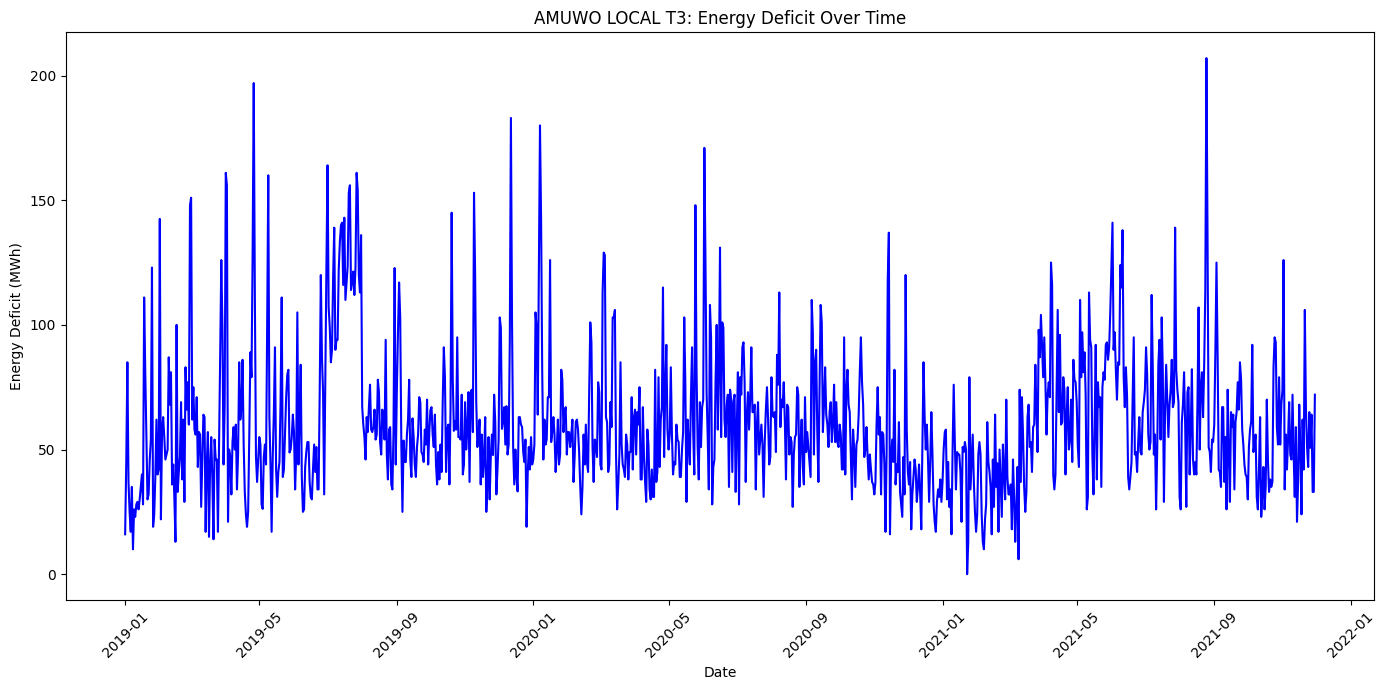

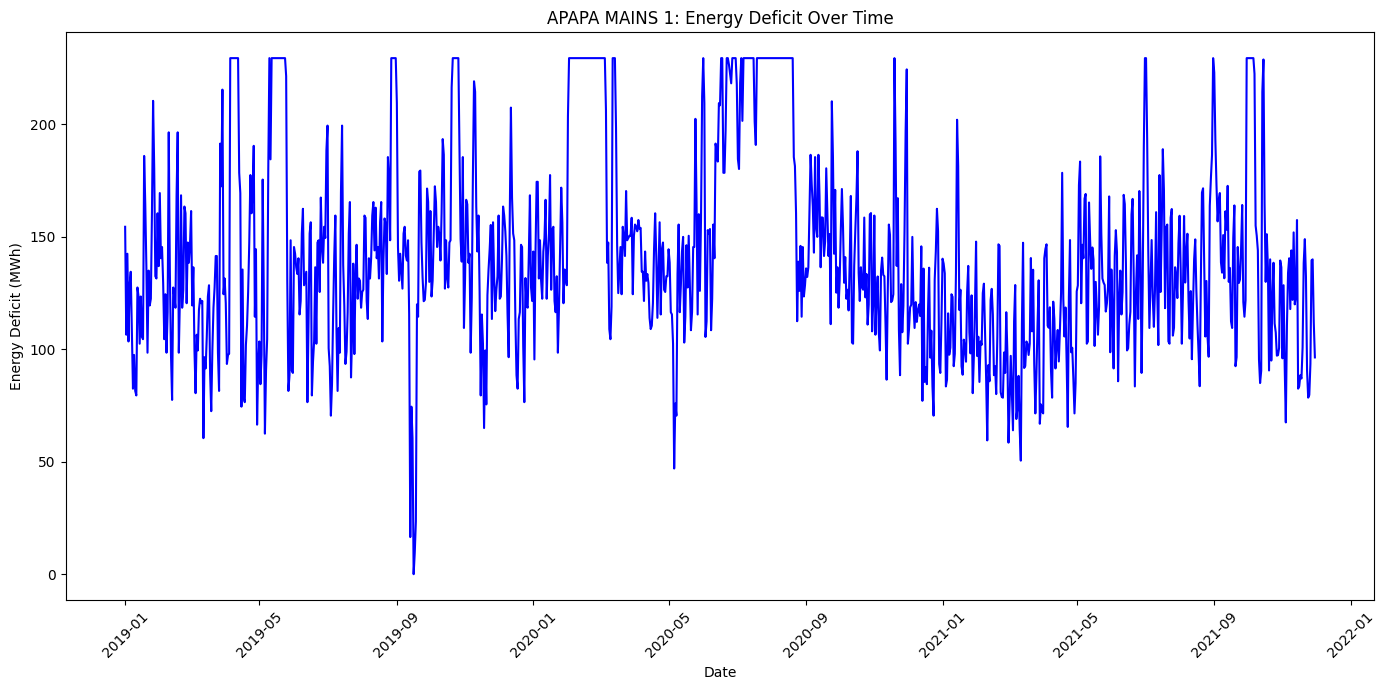

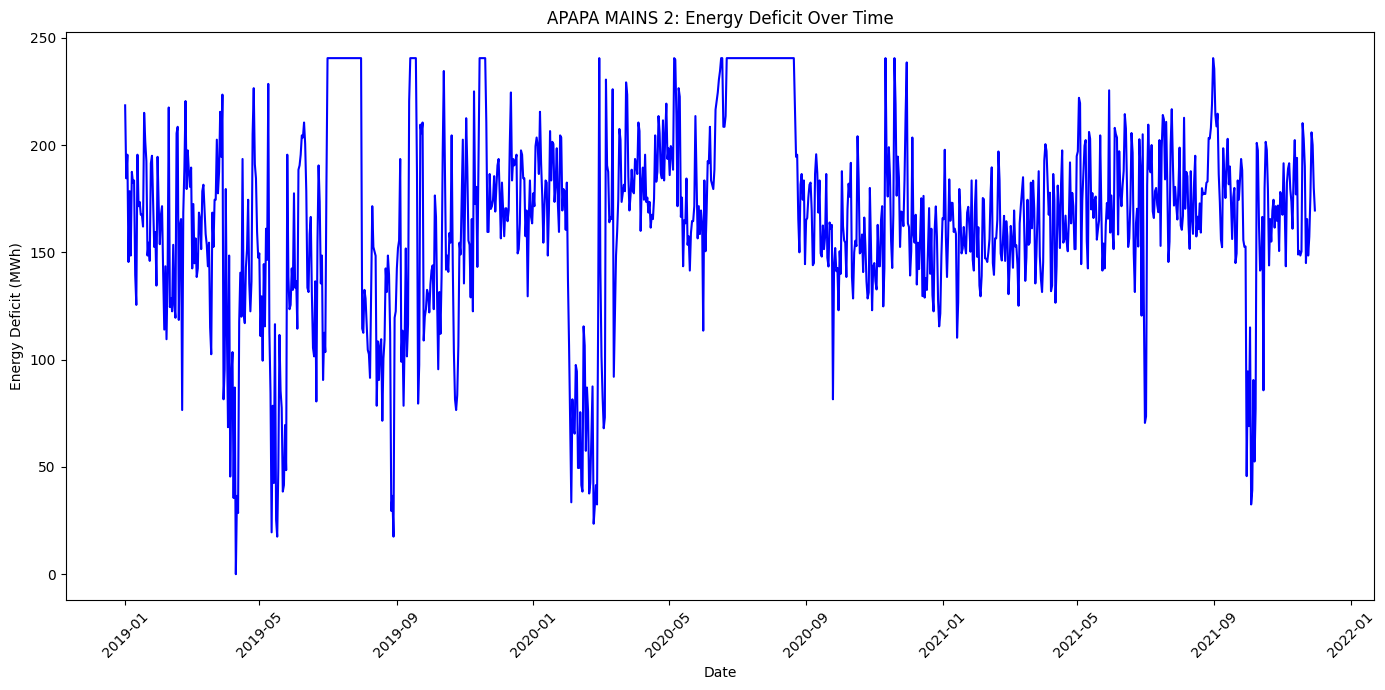

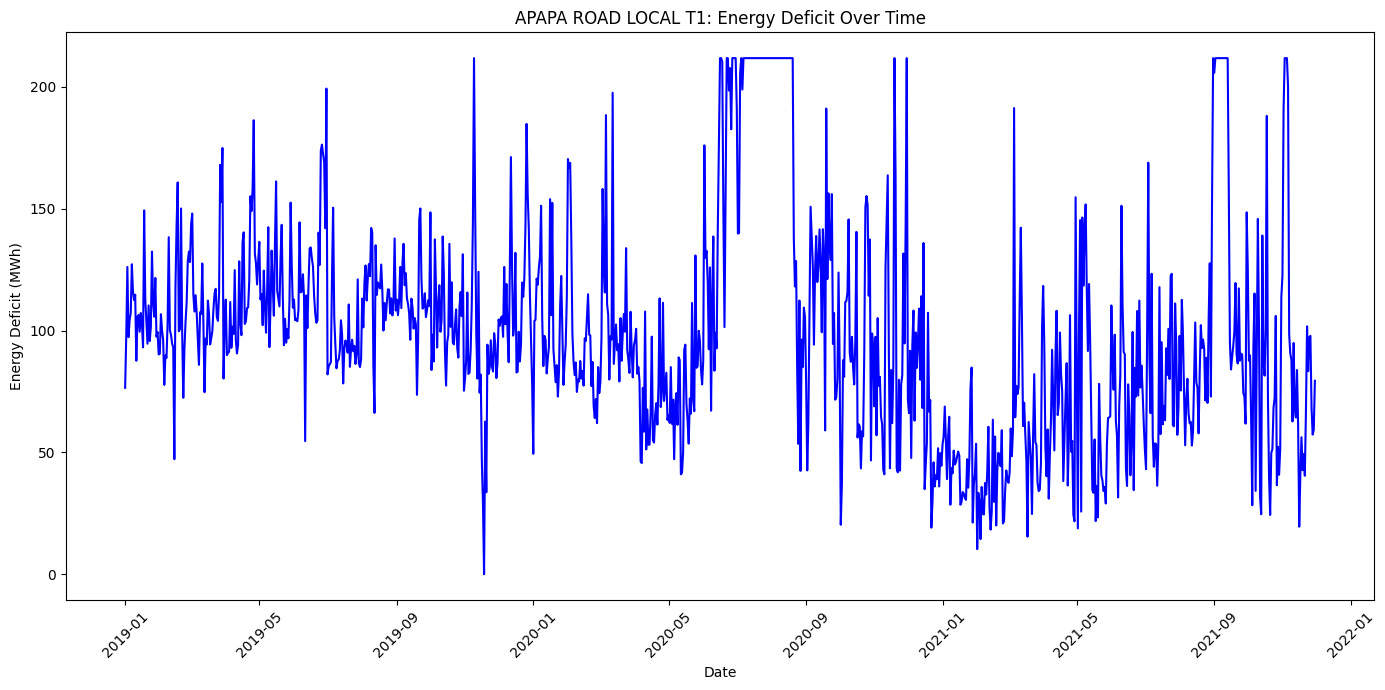

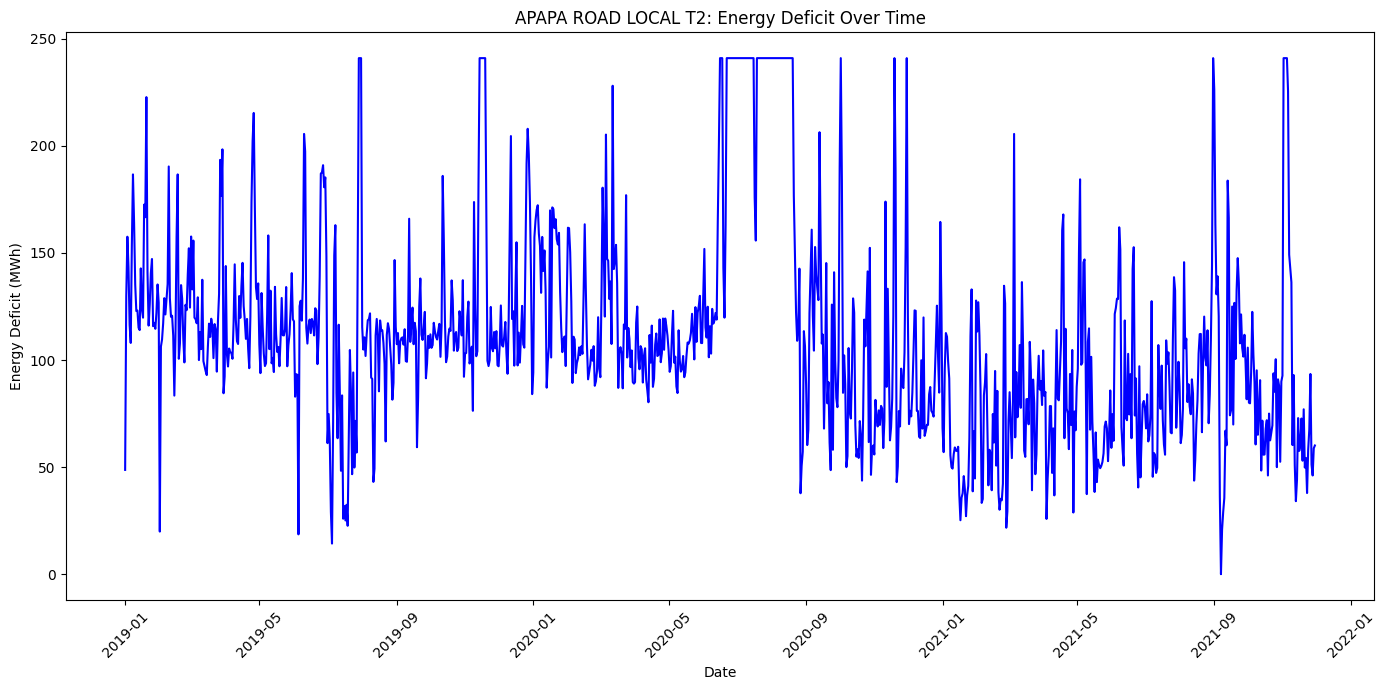

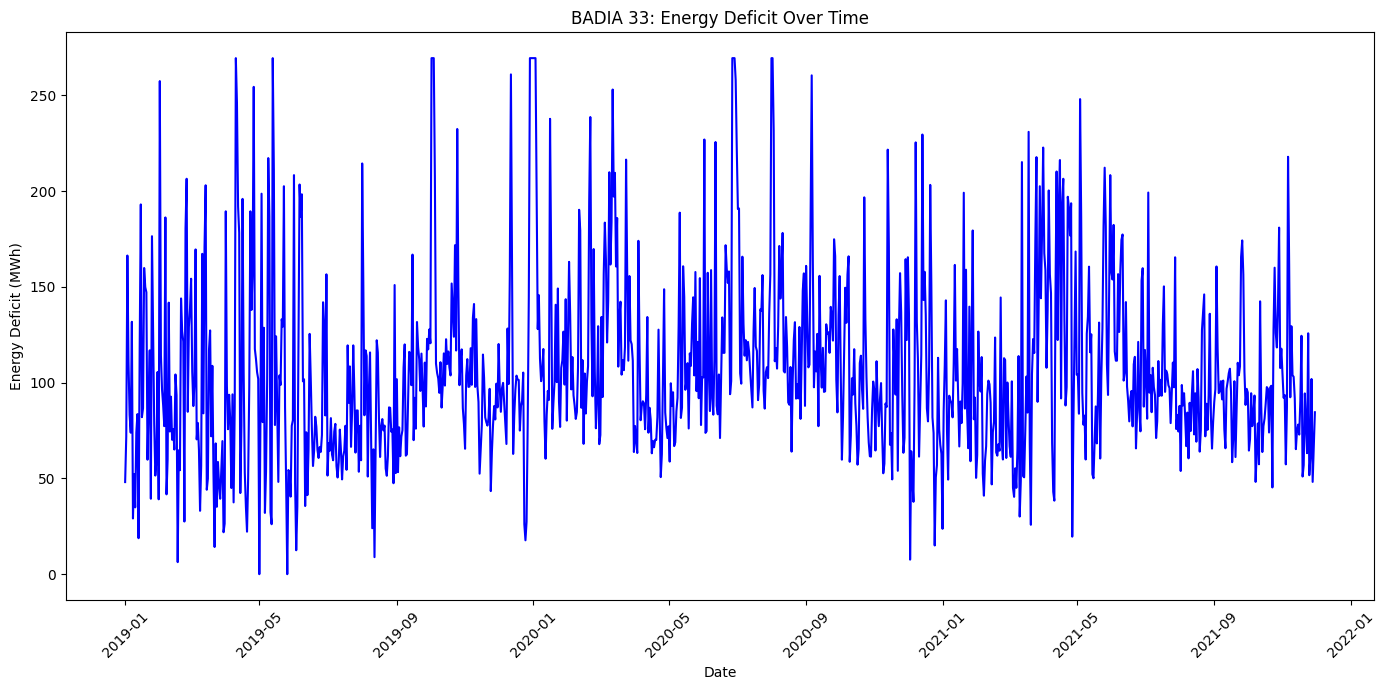

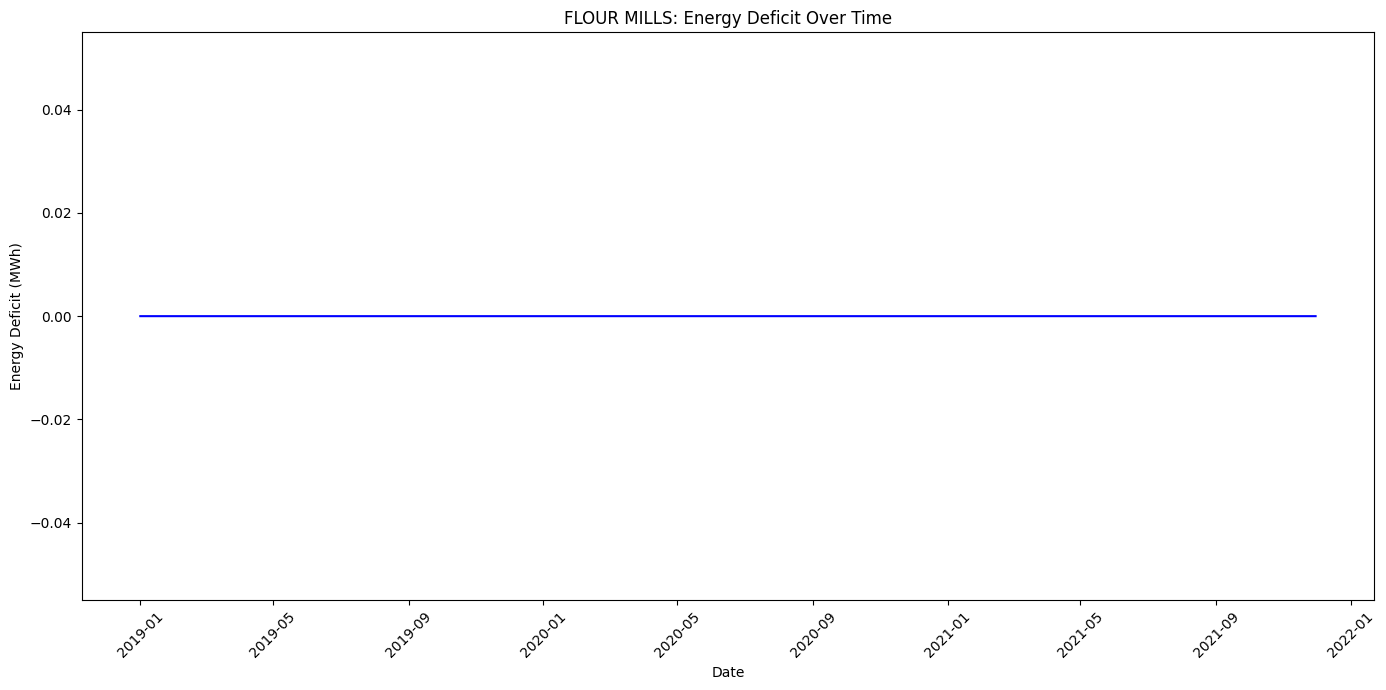

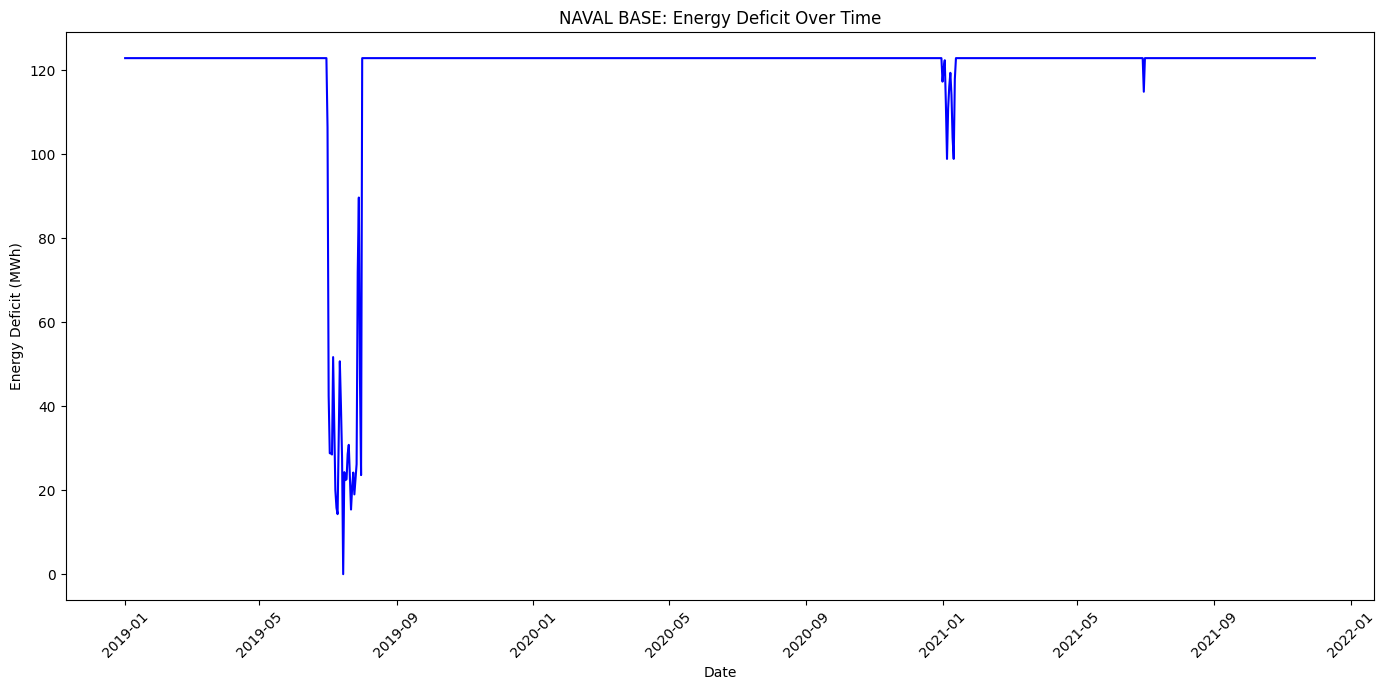

In [61]:
#Plot for AMUWO LOCAL T3
plot_energy_deficit(energy_deficit, 'AMUWO LOCAL T3')
#Plot for APAPA MAINS 1
plot_energy_deficit(energy_deficit, 'APAPA MAINS 1')

#Plot for APAPA MAINS 2
plot_energy_deficit(energy_deficit, 'APAPA MAINS 2')

#Plot for APAPA ROAD LOCAL T1
plot_energy_deficit(energy_deficit, 'APAPA ROAD LOCAL T1')

# Plot for APAPA ROAD LOCAL T2
plot_energy_deficit(energy_deficit, 'APAPA ROAD LOCAL T2')

#Plot for BADIA 33
plot_energy_deficit(energy_deficit, 'BADIA 33')


#Plot for FLOUR MILLS
plot_energy_deficit(energy_deficit, 'FLOUR MILLS')

# Plot for Naval Base
plot_energy_deficit(energy_deficit, 'NAVAL BASE') 

IJORA District Feeder Energy Deficit Plots

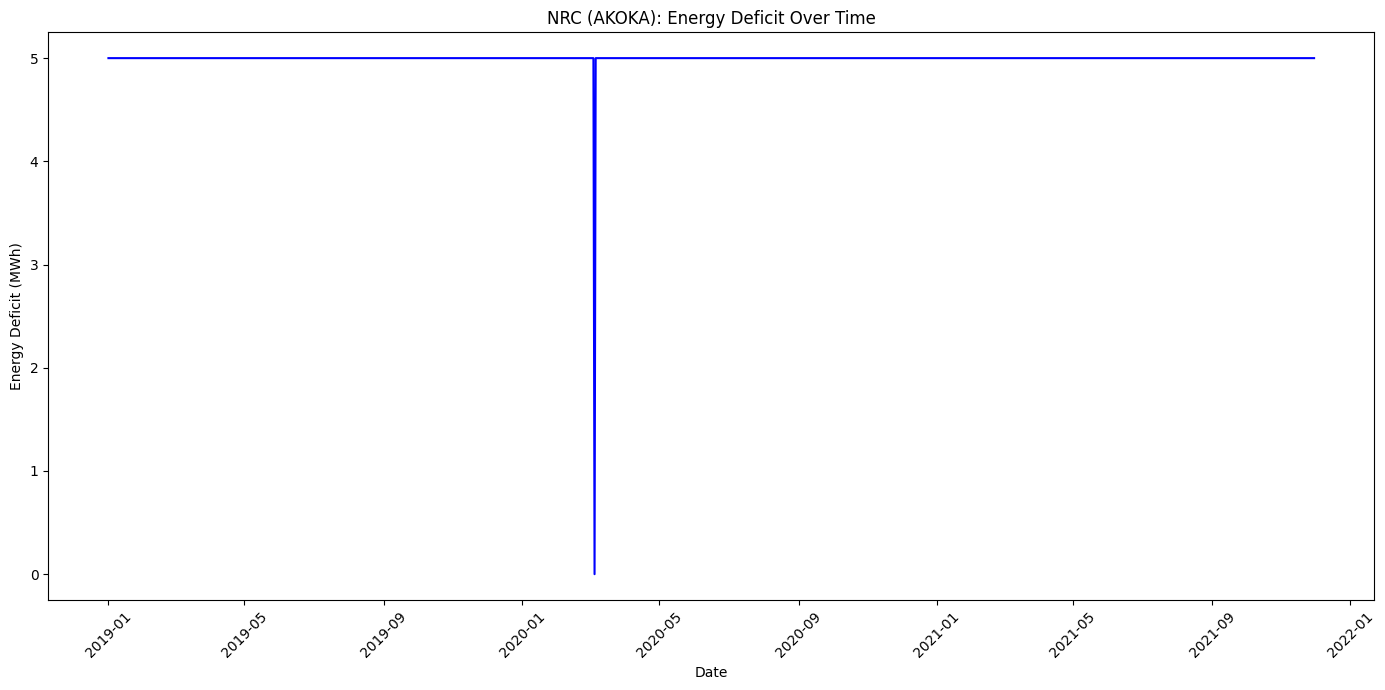

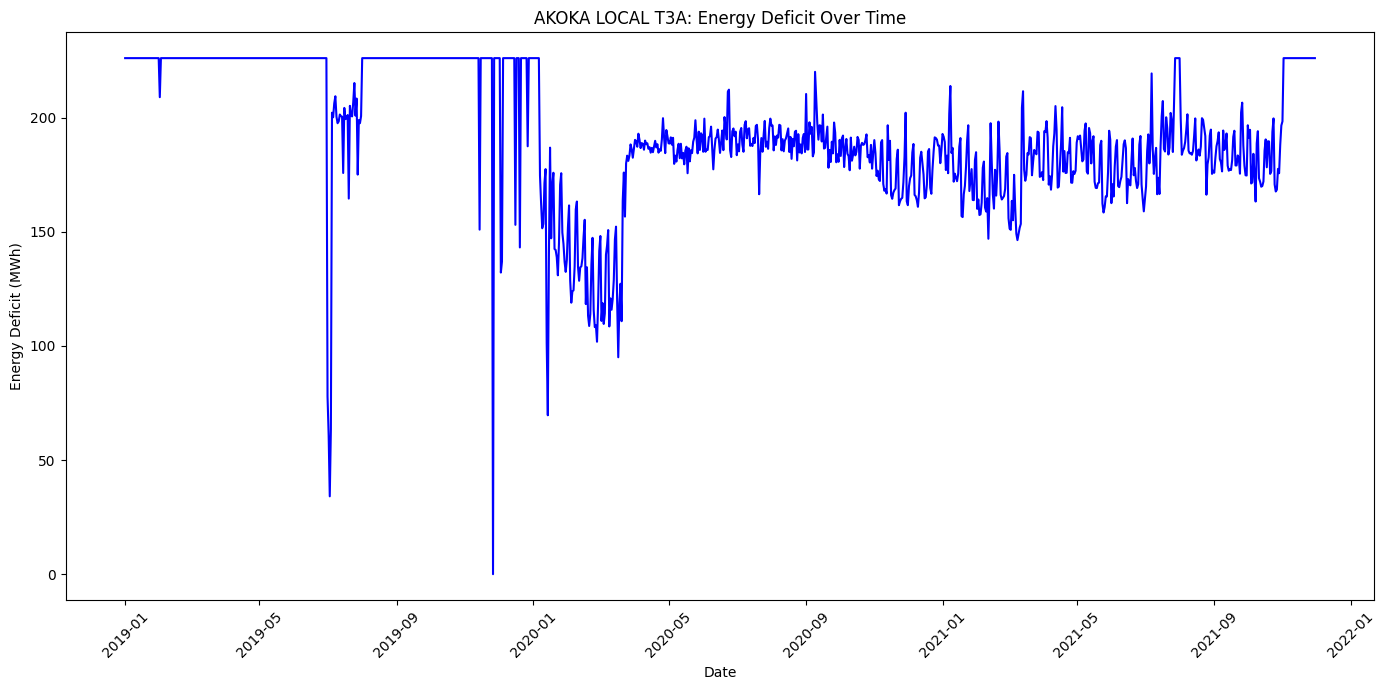

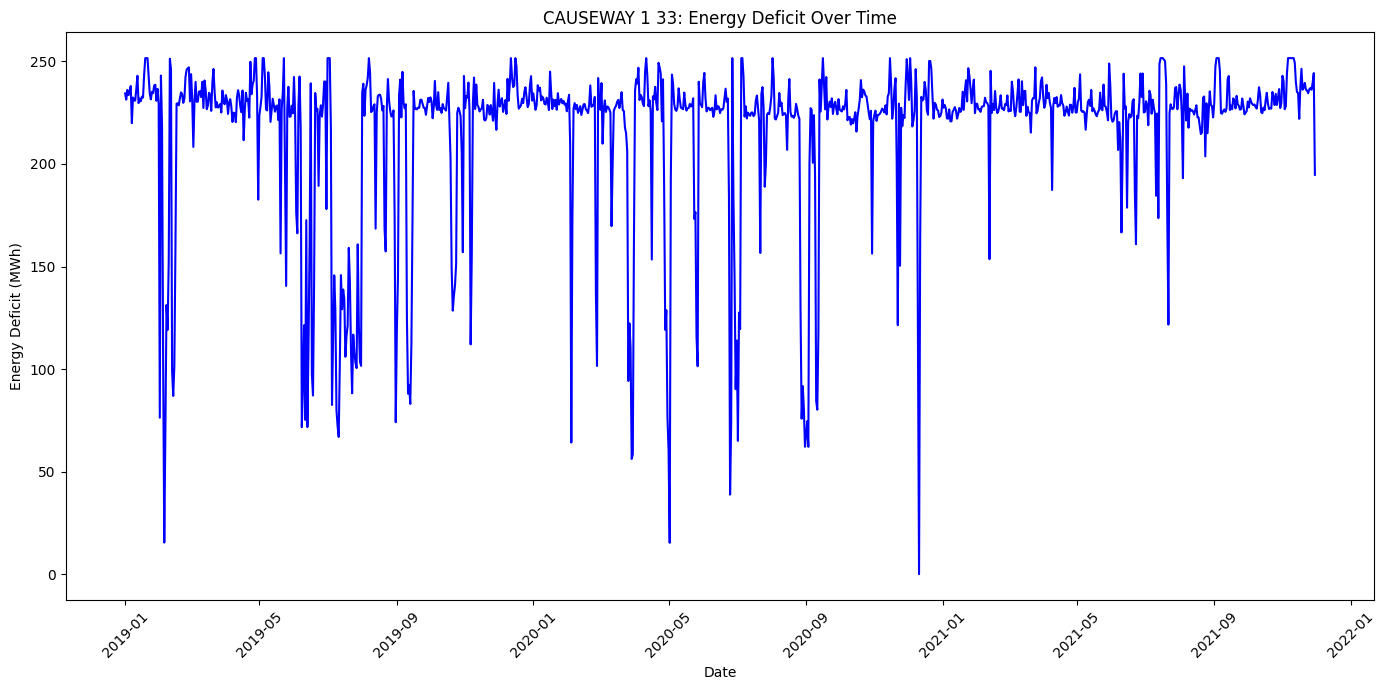

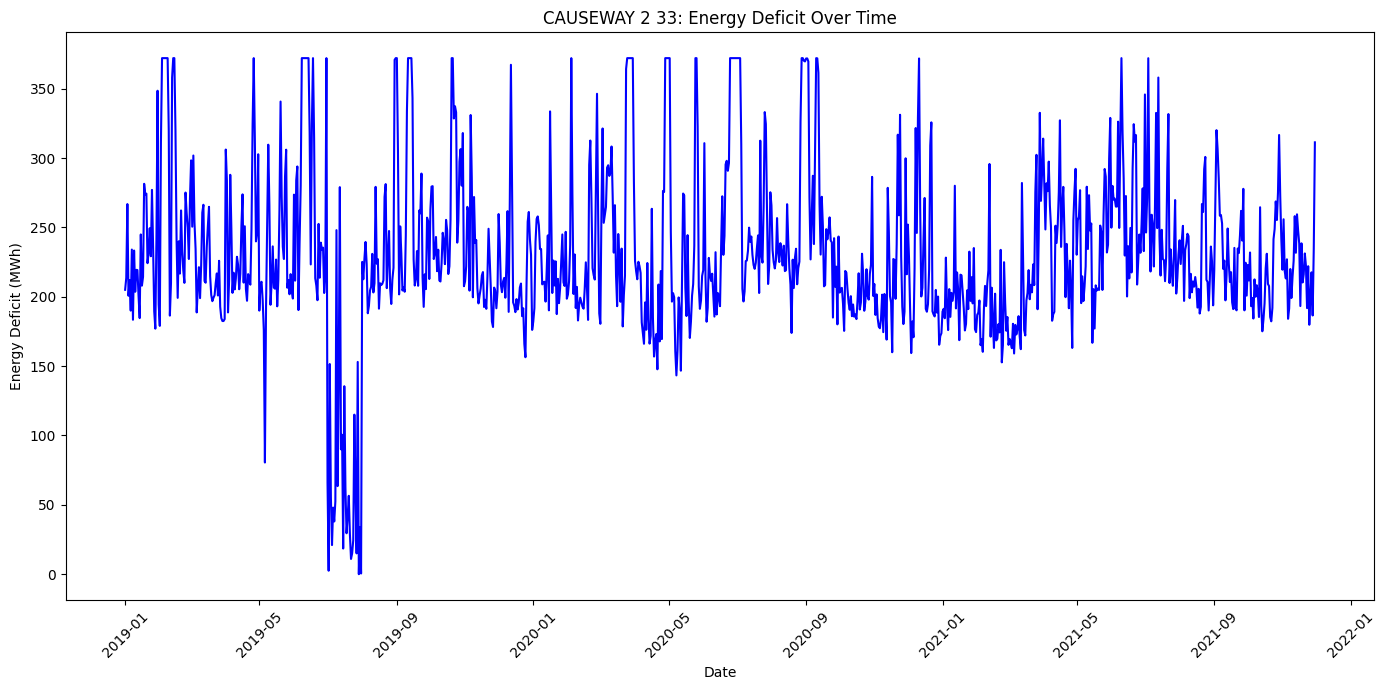

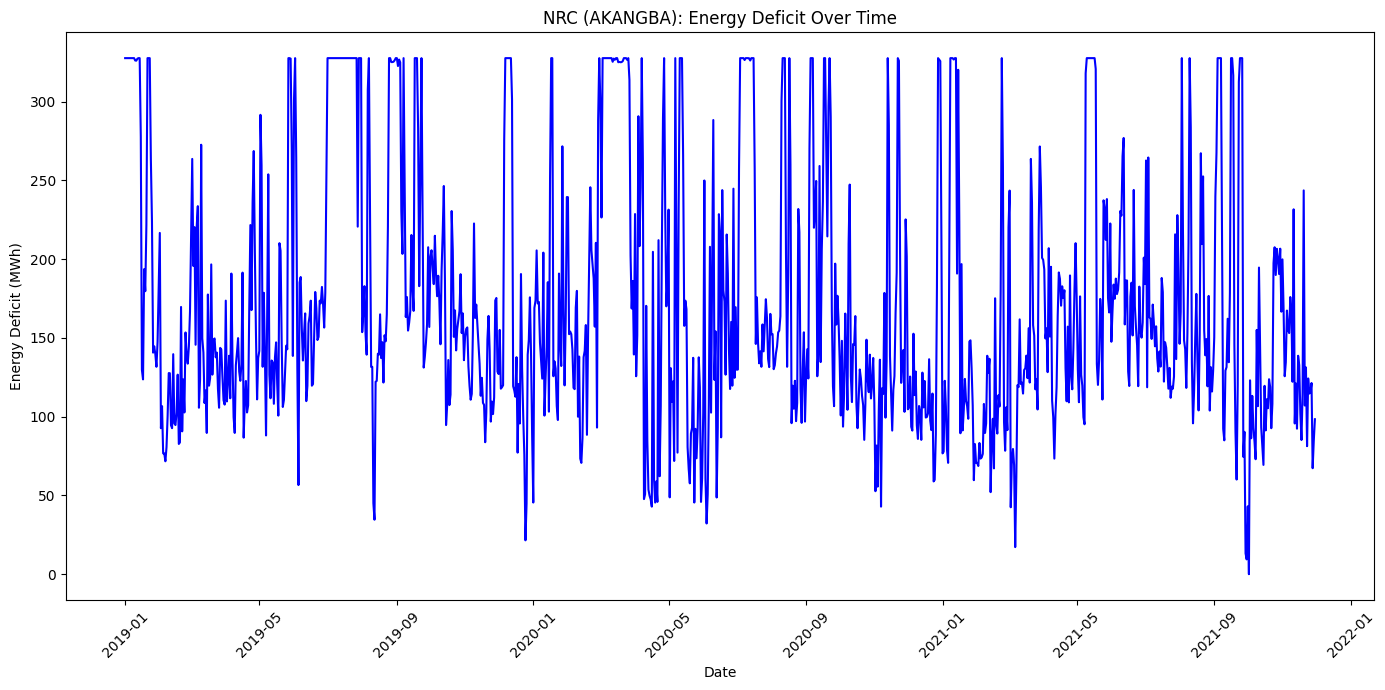

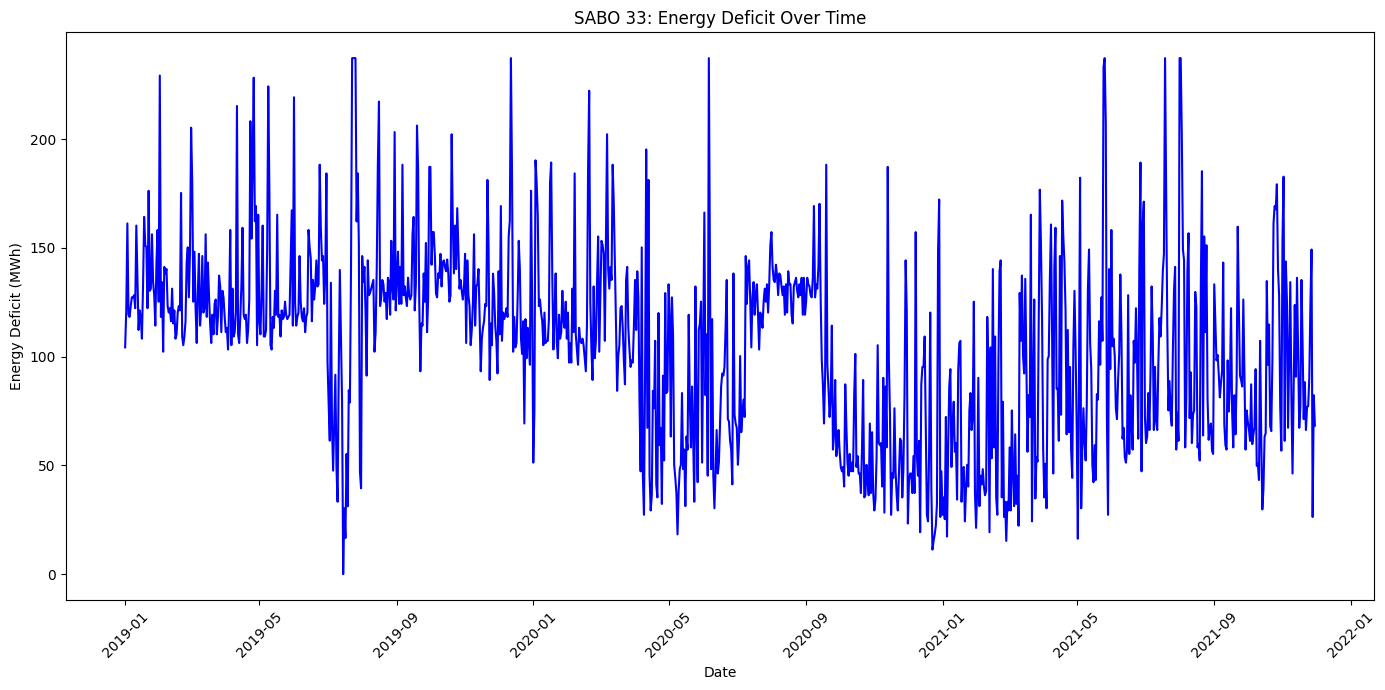

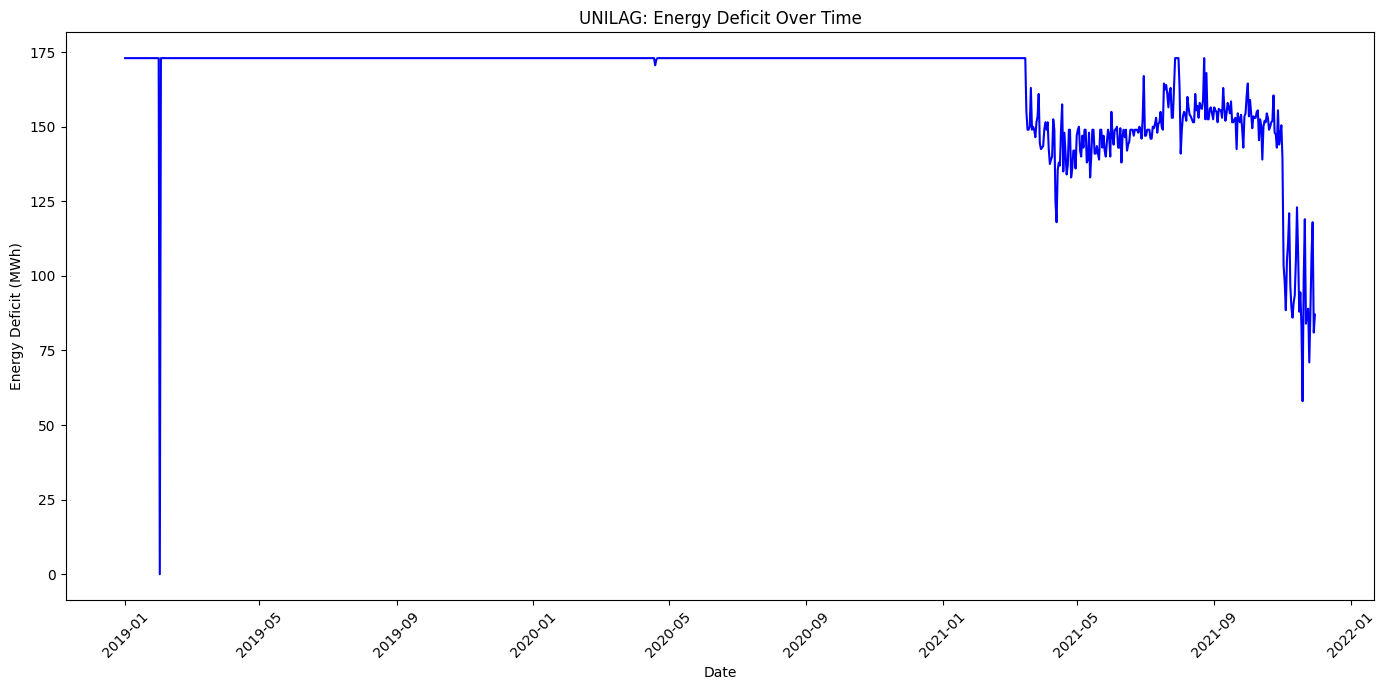

In [62]:
#Plot for NRC (AKOKA)
plot_energy_deficit(energy_deficit, 'NRC (AKOKA)')

#Plot for AKOKA LOCAL T3A
plot_energy_deficit(energy_deficit, 'AKOKA LOCAL T3A')

#Plot for CAUSEWAY 1 33
plot_energy_deficit(energy_deficit, 'CAUSEWAY 1 33')

#Plot for CAUSEWAY 2 33
plot_energy_deficit(energy_deficit, 'CAUSEWAY 2 33')

#Plot for NRC (AKANGBA)
plot_energy_deficit(energy_deficit, 'NRC (AKANGBA)')

#Plot for SABO 33
plot_energy_deficit(energy_deficit, 'SABO 33')

#Plot for UNILAG
plot_energy_deficit(energy_deficit, 'UNILAG')

In [63]:
#Plot the energy deficit for each feeder using sub plots
def plot_all_energy_deficit(df):
    num_feed = len(df.columns) - 1  # Exclude the 'date' column
    fig, axes = plt.subplots(num_feed, 1, figsize=(14, 5 * num_feed), sharex=True)
    
    for i, column in enumerate(df.columns[1:]):  # Skip the 'date' column
        sns.lineplot(data=df, x='date', y=column, ax=axes[i], label=column)
        axes[i].set_title(f'Energy Deficit for {column}')
        axes[i].set_ylabel('Energy Deficit (MWh)')
        axes[i].legend()
    
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.suptitle('Energy Deficit for Each Feeder', fontsize=16, y=1.02)
    plt.show()


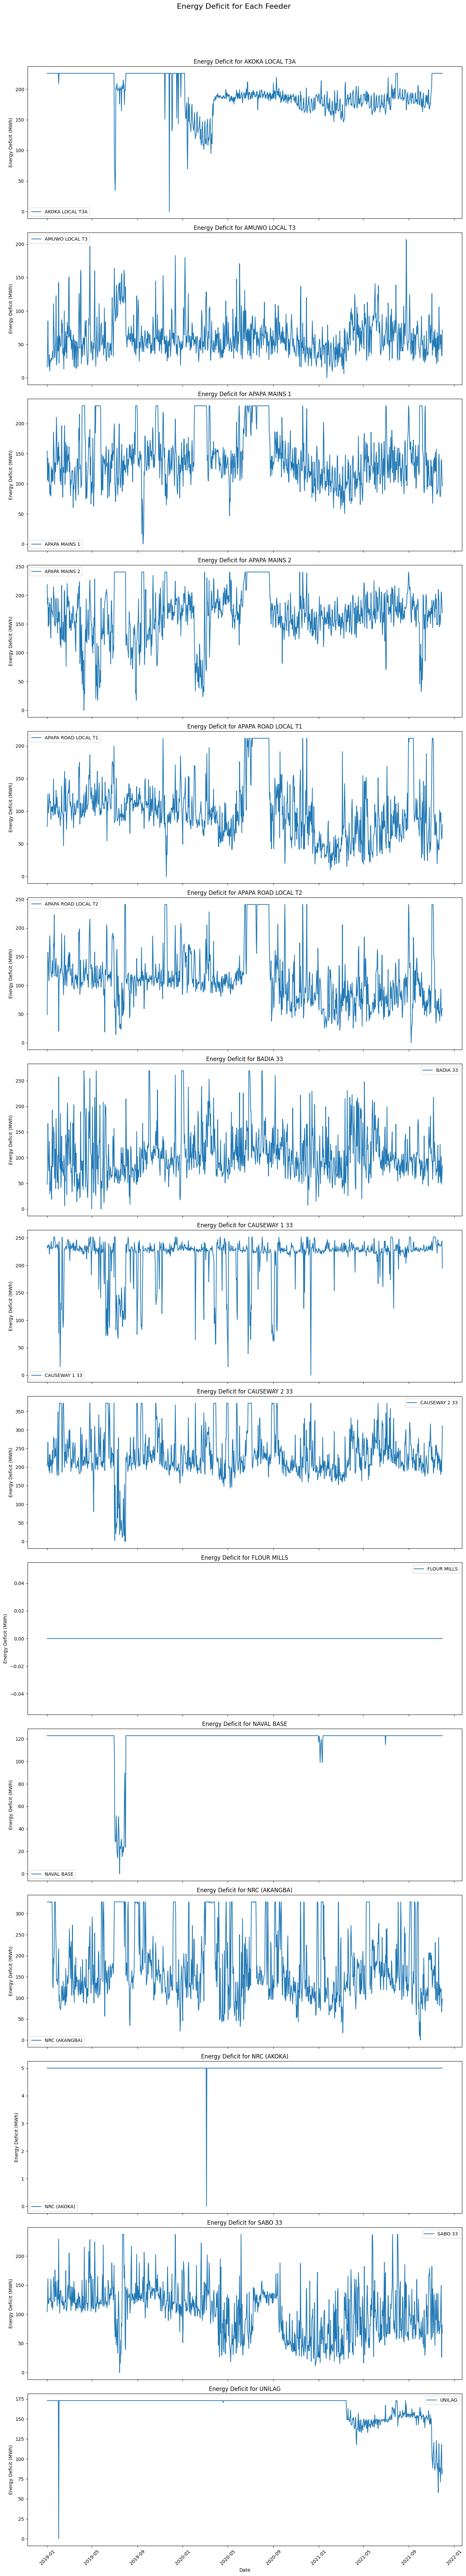

In [64]:
plot_all_energy_deficit(energy_deficit)

In [65]:
# Calculate and create dataframe for the total energy deficit across the feeder
# formula is:
# Total energy deficit = total max capacity - sum of each feeder energy deficit
# Where; total max capacity= sum of all the maximum consumption values of each feeder

total_max_capacity = feeder_cons_df.drop(columns=['date']).max().sum()
print(f"Total Max Capacity: {total_max_capacity}\n")
feeder_energy_deficit= energy_deficit.drop(columns=['date']).sum(axis=1)
print(f"Total Max Energy Deficit: {feeder_energy_deficit}")

Total Max Capacity: 3114.800000000001

Total Max Energy Deficit: 0       1960.60
1       2056.40
2       2391.90
3       2045.70
4       2055.90
         ...   
1060    1692.39
1061    1816.54
1062    1516.10
1063    1591.30
1064    1675.57
Length: 1065, dtype: float64


In [66]:
# Create a new column for the total energy deficit and add the column to the previous energy deficit dataframe

energy_deficit["total_max_capacity"] = feeder_cons_df.drop(columns=['date']).max().sum()
energy_deficit["total_feeder_deficit"] = energy_deficit.drop(columns=['date']).sum(axis=1)

# Calculate total energy deficit
energy_deficit['total_energy_deficit'] = energy_deficit["total_feeder_deficit"] - energy_deficit["total_max_capacity"]
energy_deficit

33kv_feeder       date  AKOKA LOCAL T3A  AMUWO LOCAL T3  APAPA MAINS 1  \
0           2019-01-01            226.0            16.0          154.5   
1           2019-01-02            226.0            45.0          106.5   
2           2019-01-03            226.0            85.0          142.5   
3           2019-01-04            226.0            37.0          103.5   
4           2019-01-05            226.0            25.0          128.5   
...                ...              ...             ...            ...   
1060        2021-11-26            226.0            50.7           93.6   
1061        2021-11-27            226.0            64.0          139.6   
1062        2021-11-28            226.0            33.0          140.0   
1063        2021-11-29            226.0            33.0          112.0   
1064        2021-11-30            226.0            72.0           96.4   

33kv_feeder  APAPA MAINS 2  APAPA ROAD LOCAL T1  APAPA ROAD LOCAL T2  \
0                    218.5                 76.5                 48.7   
1                    184.5                 98.0                129.7   
2                    195.5                126.1                157.6   
3                    145.5                 97.3                143.4   
4                    178.5                104.3                116.4   
...                    ...                  ...                  ...   
1060                 176.3                 97.8                 93.5   
1061                 205.9                 68.5                 51.2   
1062                 200.0                 57.3                 46.1   
1063                 180.0                 59.3                 58.8   
1064                 169.5                 79.4                 60.1   

33kv_feeder  BADIA 33  CAUSEWAY 1 33  CAUSEWAY 2 33  FLOUR MILLS  NAVAL BASE  \
0               48.10          234.4         205.00          0.0       122.9   
1               71.80          231.4         213.60          0.0       122.9   
2              166.40          236.1         266.80          0.0       122.9   
3              110.80          233.6         200.70          0.0       122.9   
4               83.20          235.2         211.90          0.0       122.9   
...               ...            ...            ...          ...         ...   
1060            61.30          237.0         200.79          0.0       122.9   
1061           101.94          236.2         217.60          0.0       122.9   
1062            48.20          239.5         186.50          0.0       122.9   
1063            67.20          244.3         234.90          0.0       122.9   
1064            84.57          194.7         311.30          0.0       122.9   

33kv_feeder  NRC (AKANGBA)  NRC (AKOKA)  SABO 33  UNILAG  total_max_capacity  \
0                    327.7          5.0    104.3   173.0              3114.8   
1                    327.7          5.0    121.3   173.0              3114.8   
2                    327.7          5.0    161.3   173.0              3114.8   
3                    327.7          5.0    119.3   173.0              3114.8   
4                    327.7          5.0    118.3   173.0              3114.8   
...                    ...          ...      ...     ...                 ...   
1060                 115.2          5.0    124.3    88.0              3114.8   
1061                 121.4          5.0    149.3   107.0              3114.8   
1062                  67.3          5.0     26.3   118.0              3114.8   
1063                  84.6          5.0     82.3    81.0              3114.8   
1064                  98.4          5.0     68.3    87.0              3114.8   

33kv_feeder  total_feeder_deficit  total_energy_deficit  
0                         5075.40               1960.60  
1                         5171.20               2056.40  
2                         5506.70               2391.90  
3                         5160.50               2045.70  
4                         5170.70 

In [67]:
#Clean the energy_deficit df by renaming the columns
energy_deficit= energy_deficit.rename(
    columns= lambda x: x.strip().lower().replace(' ', '_') if isinstance(x, str) else x
)
energy_deficit

33kv_feeder       date  akoka_local_t3a  amuwo_local_t3  apapa_mains_1  \
0           2019-01-01            226.0            16.0          154.5   
1           2019-01-02            226.0            45.0          106.5   
2           2019-01-03            226.0            85.0          142.5   
3           2019-01-04            226.0            37.0          103.5   
4           2019-01-05            226.0            25.0          128.5   
...                ...              ...             ...            ...   
1060        2021-11-26            226.0            50.7           93.6   
1061        2021-11-27            226.0            64.0          139.6   
1062        2021-11-28            226.0            33.0          140.0   
1063        2021-11-29            226.0            33.0          112.0   
1064        2021-11-30            226.0            72.0           96.4   

33kv_feeder  apapa_mains_2  apapa_road_local_t1  apapa_road_local_t2  \
0                    218.5                 76.5                 48.7   
1                    184.5                 98.0                129.7   
2                    195.5                126.1                157.6   
3                    145.5                 97.3                143.4   
4                    178.5                104.3                116.4   
...                    ...                  ...                  ...   
1060                 176.3                 97.8                 93.5   
1061                 205.9                 68.5                 51.2   
1062                 200.0                 57.3                 46.1   
1063                 180.0                 59.3                 58.8   
1064                 169.5                 79.4                 60.1   

33kv_feeder  badia_33  causeway_1_33  causeway_2_33  flour_mills  naval_base  \
0               48.10          234.4         205.00          0.0       122.9   
1               71.80          231.4         213.60          0.0       122.9   
2              166.40          236.1         266.80          0.0       122.9   
3              110.80          233.6         200.70          0.0       122.9   
4               83.20          235.2         211.90          0.0       122.9   
...               ...            ...            ...          ...         ...   
1060            61.30          237.0         200.79          0.0       122.9   
1061           101.94          236.2         217.60          0.0       122.9   
1062            48.20          239.5         186.50          0.0       122.9   
1063            67.20          244.3         234.90          0.0       122.9   
1064            84.57          194.7         311.30          0.0       122.9   

33kv_feeder  nrc_(akangba)  nrc_(akoka)  sabo_33  unilag  total_max_capacity  \
0                    327.7          5.0    104.3   173.0              3114.8   
1                    327.7          5.0    121.3   173.0              3114.8   
2                    327.7          5.0    161.3   173.0              3114.8   
3                    327.7          5.0    119.3   173.0              3114.8   
4                    327.7          5.0    118.3   173.0              3114.8   
...                    ...          ...      ...     ...                 ...   
1060                 115.2          5.0    124.3    88.0              3114.8   
1061                 121.4          5.0    149.3   107.0              3114.8   
1062                  67.3          5.0     26.3   118.0              3114.8   
1063                  84.6          5.0     82.3    81.0              3114.8   
1064                  98.4          5.0     68.3    87.0              3114.8   

33kv_feeder  total_feeder_deficit  total_energy_deficit  
0                         5075.40               1960.60  
1                         5171.20               2056.40  
2                         5506.70               2391.90  
3                         5160.50               2045.70  
4                         5170.70 

#### EDA for Energy Deficit Data

In [68]:
# Check the statistics of the energy deficit DataFrame
energy_stat= energy_deficit.describe()
#save the energy deficit statistics to a csv file
energy_stat.to_csv(os.path.join(clean_data_path, 'energy_deficit_stat.csv'))

In [72]:
# Check the correlation of the energy deficit DataFrame
energy_deficit.corr()

33kv_feeder               date  akoka_local_t3a  amuwo_local_t3  \
33kv_feeder                                                       
date                  1.000000        -0.409190       -0.049996   
akoka_local_t3a      -0.409190         1.000000       -0.022387   
amuwo_local_t3       -0.049996        -0.022387        1.000000   
apapa_mains_1        -0.109624        -0.049241        0.139953   
apapa_mains_2         0.128485         0.013959        0.233442   
apapa_road_local_t1  -0.226354         0.191152        0.188796   
apapa_road_local_t2  -0.257321         0.138565        0.136401   
badia_33              0.035603        -0.068085        0.253241   
causeway_1_33         0.185269        -0.047248       -0.113412   
causeway_2_33        -0.005012         0.119572        0.050175   
flour_mills                NaN              NaN             NaN   
naval_base            0.177675         0.059267       -0.349552   
nrc_(akangba)        -0.153680        -0.038281        0.286517   
nrc_(akoka)           0.010271         0.082434       -0.072377   
sabo_33              -0.380764         0.267170        0.238134   
unilag               -0.568803        -0.018994       -0.066824   
total_max_capacity         NaN              NaN             NaN   
total_feeder_deficit -0.254784         0.219595        0.396216   
total_energy_deficit -0.254784         0.219595        0.396216   

33kv_feeder           apapa_mains_1  apapa_mains_2  apapa_road_local_t1  \
33kv_feeder                                                               
date                      -0.109624       0.128485            -0.226354   
akoka_local_t3a           -0.049241       0.013959             0.191152   
amuwo_local_t3             0.139953       0.233442             0.188796   
apapa_mains_1              1.000000      -0.037789             0.505979   
apapa_mains_2             -0.037789       1.000000             0.282472   
apapa_road_local_t1        0.505979       0.282472             1.000000   
apapa_road_local_t2        0.437767       0.342245             0.665247   
badia_33                   0.190092       0.041491             0.164837   
causeway_1_33             -0.001493      -0.091635            -0.012342   
causeway_2_33              0.175849      -0.042597             0.180806   
flour_mills                     NaN            NaN                  NaN   
naval_base                 0.089702      -0.270837             0.031867   
nrc_(akangba)              0.099204       0.204977             0.190629   
nrc_(akoka)               -0.058736       0.063688            -0.009975   
sabo_33                    0.189179      -0.037639             0.283263   
unilag                     0.177657      -0.028311             0.154617   
total_max_capacity              NaN            NaN                  NaN   
total_feeder_deficit       0.530037       0.351183             0.707091   
total_energy_deficit       0.530037       0.351183             0.707091   

33kv_feeder           apapa_road_local_t2  badia_33  causeway_1_33  \
33kv_feeder                                                          
date                            -0.257321  0.035603       0.185269   
akoka_local_t3a                  0.138565 -0.068085      -0.047248   
amuwo_local_t3                   0.136401  0.253241      -0.113412   
apapa_mains_1                    0.437767  0.190092      -0.001493   
apapa_mains_2                    0.342245  0.041491      -0.091635   
apapa_road_local_t1              0.665247  0.164837      -0.012342   
apapa_road_local_t2              1.000000  0.202026      -0.004502   
badia_33                         0.202026  1.000000       0.073380   
causeway_1_33                   -0.004502  0.073380       1.000000   
causeway_2_33                    0.189763  0.341871      -0.345722   
flour_mills                           NaN       NaN            NaN   
naval_base                       0.110634  0.118869       0.372139   
nrc_(akangba)                    0.1

In [70]:
energy_deficit.shape

(1065, 19)

In [71]:
# Save the energy_deficit dataframe
energy_deficit.to_csv(os.path.join(clean_data_path, "energy_deficit.csv"))